# Visualize Monitor Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget


# === CONFIGURATION ===
# --- Step 1: Set the name of your .txt file here ---
filename = "../data/sensor_data.csv"  # <--- CHANGE THIS

collumn_names = ['ax', 'ay', 'az', 'state', 'ultrasound', 'step_detected']
df = pd.read_csv(filename, header=1, names=collumn_names)
# === ADD THE NEW COLUMN ===
# Calculate the acceleration magnitude using the formula sqrt(ax^2 + ay^2 + az^2)
# and add it as a new column called 'accel_magnitude'.
df['accel_magnitude'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
print(f"Successfully loaded '{filename}'.")
print(f"Found {len(df)} rows and {df.shape[1]} columns of data.")

# --- Step 2: Define the titles for your plots ---
titles = [
    "Accel X (g)", "Accel Y (g)", "Accel Z (g)",
    "Gyro X (°/s)", "Gyro Y (°/s)", "Gyro Z (°/s)"
]

# o -1 TIRA O OFFSET DA GRAVIDADE JÁ !!!!
df['accel_magnitude'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2) - 1


Successfully loaded '../data/sensor_data.csv'.
Found 20431 rows and 7 columns of data.


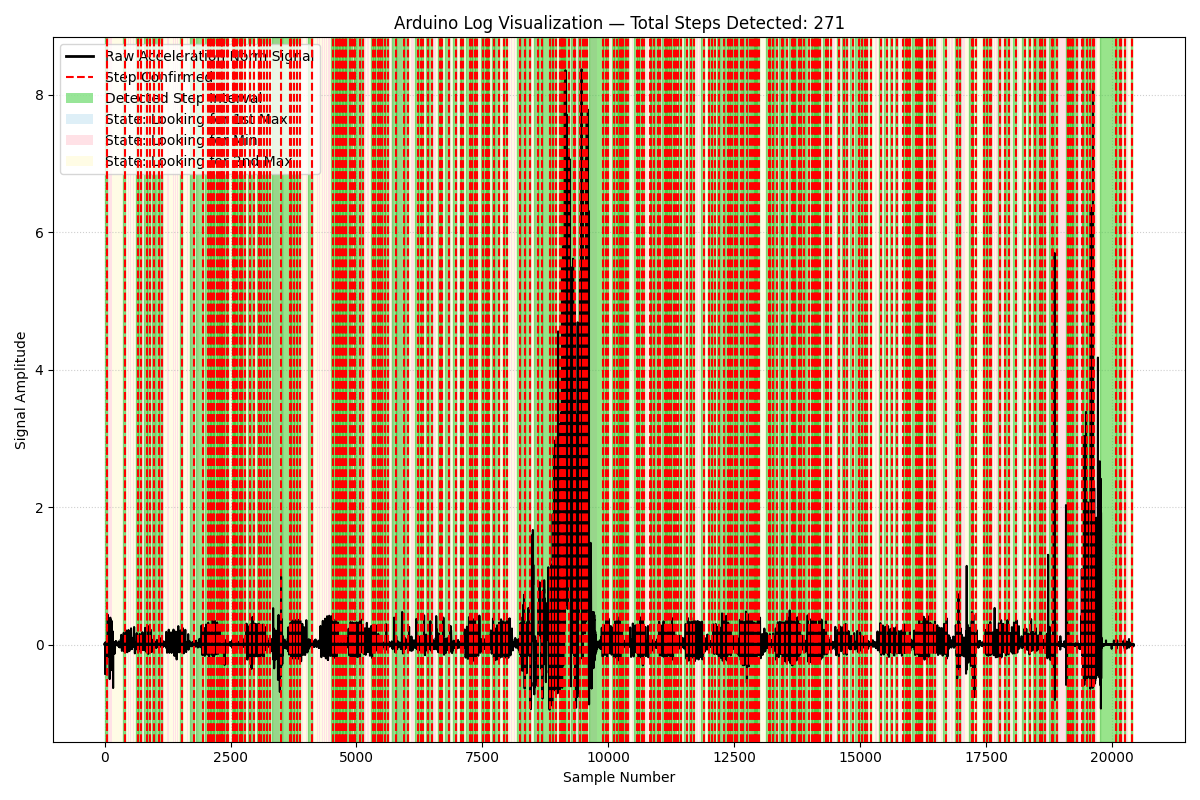

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# --- 2. Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))

# A. Plot the main signal line
ax.plot(df['accel_magnitude'], label='Signal', color='black', zorder=10)

# B. Plot the FSM State Zones from the 'state' column of your DataFrame
state_colors = {
    'LOOKING_FOR_FIRST_MAX': (173/255.0, 216/255.0, 230/250.0, 0.4), # Light Blue
    'LOOKING_FOR_MIN':       (255/255.0, 182/255.0, 193/255.0, 0.4), # Light Pink
    'LOOKING_FOR_SECOND_MAX':(255/255.0, 250/255.0, 205/255.0, 0.5)  # Light Yellow
}

start_index = 0
current_state = df['state'].iloc[0]
for i in range(1, len(df)):
    if df['state'].iloc[i] != current_state:
        ax.axvspan(start_index, i, facecolor=state_colors.get(current_state), zorder=1, edgecolor=None)
        start_index = i
        current_state = df['state'].iloc[i]
ax.axvspan(start_index, len(df) - 1, facecolor=state_colors.get(current_state), zorder=1, edgecolor=None)


# C. Find and plot the "Detected Interval" zones from the DataFrame
step_end_indices = df[df['step_detected'] == 1].index

# Reconstruct the intervals by looking backwards from each detected step
reconstructed_intervals = []
for end_idx in step_end_indices:
    # The state at the end index resets to LOOKING_FOR_MIN.
    # We search backwards from the sample *before* it.
    current_idx = end_idx - 1
    # Step 1: Go back through the "LOOKING_FOR_SECOND_MAX" phase
    while current_idx > 0 and df['state'].iloc[current_idx] == 'LOOKING_FOR_SECOND_MAX':
        current_idx -= 1
    # Step 2: Go back through the "LOOKING_FOR_MIN" phase to find the start peak
    start_idx = current_idx
    while start_idx > 0 and df['state'].iloc[start_idx] == 'LOOKING_FOR_MIN':
        start_idx -= 1
    reconstructed_intervals.append((start_idx, end_idx))

if reconstructed_intervals:
    for i, interval in enumerate(reconstructed_intervals):
        ax.axvspan(interval[0], interval[1], color='limegreen', alpha=0.5, zorder=2)
        ax.axvline(x=interval[1], color='red', linestyle='--', linewidth=1.5, zorder=11)


# D. Create a comprehensive legend and finalize the plot
legend_elements = [
    plt.Line2D([0], [0], color='black', lw=2, label='Raw Acceleration Norm Signal'),
    plt.Line2D([0], [0], color='red', linestyle='--', lw=1.5, label='Step Confirmed'),
    Patch(facecolor='limegreen', alpha=0.5, label='Detected Step Interval'),
    Patch(facecolor=state_colors['LOOKING_FOR_FIRST_MAX'], label='State: Looking for 1st Max'),
    Patch(facecolor=state_colors['LOOKING_FOR_MIN'], label='State: Looking for Min'),
    Patch(facecolor=state_colors['LOOKING_FOR_SECOND_MAX'], label='State: Looking for 2nd Max')
]
ax.legend(handles=legend_elements, loc='best')
ax.set_title(f'Arduino Log Visualization — Total Steps Detected: {len(reconstructed_intervals)}')
ax.set_xlabel('Sample Number')
ax.set_ylabel('Signal Amplitude')
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Filtering

### First part: Exponential moving average

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def exponential_moving_average(signal, alpha):
    """Calculates the Exponential Moving Average of a signal."""
    filtered_signal = [signal[0]]
    for i in range(1, len(signal)):
        new_filtered_value = (alpha * signal[i]) + ((1 - alpha) * filtered_signal[-1])
        filtered_signal.append(new_filtered_value)
    return np.array(filtered_signal)

# --- Apply the custom filters ---
# Apply Exponential Moving Average with a smoothing factor of 0.1
# A smaller alpha means more smoothing.
alpha = 0.1
df['ax_lp'] = exponential_moving_average(df['ax'] , alpha=alpha)
df['ay_lp'] = exponential_moving_average(df['ay'] , alpha=alpha)
df['az_lp'] = exponential_moving_average(df['az'] , alpha=alpha)

df['accel_magnitude_lp'] = np.sqrt(df['ax_lp']**2 + df['ay_lp']**2 + df['az_lp']**2) - 1



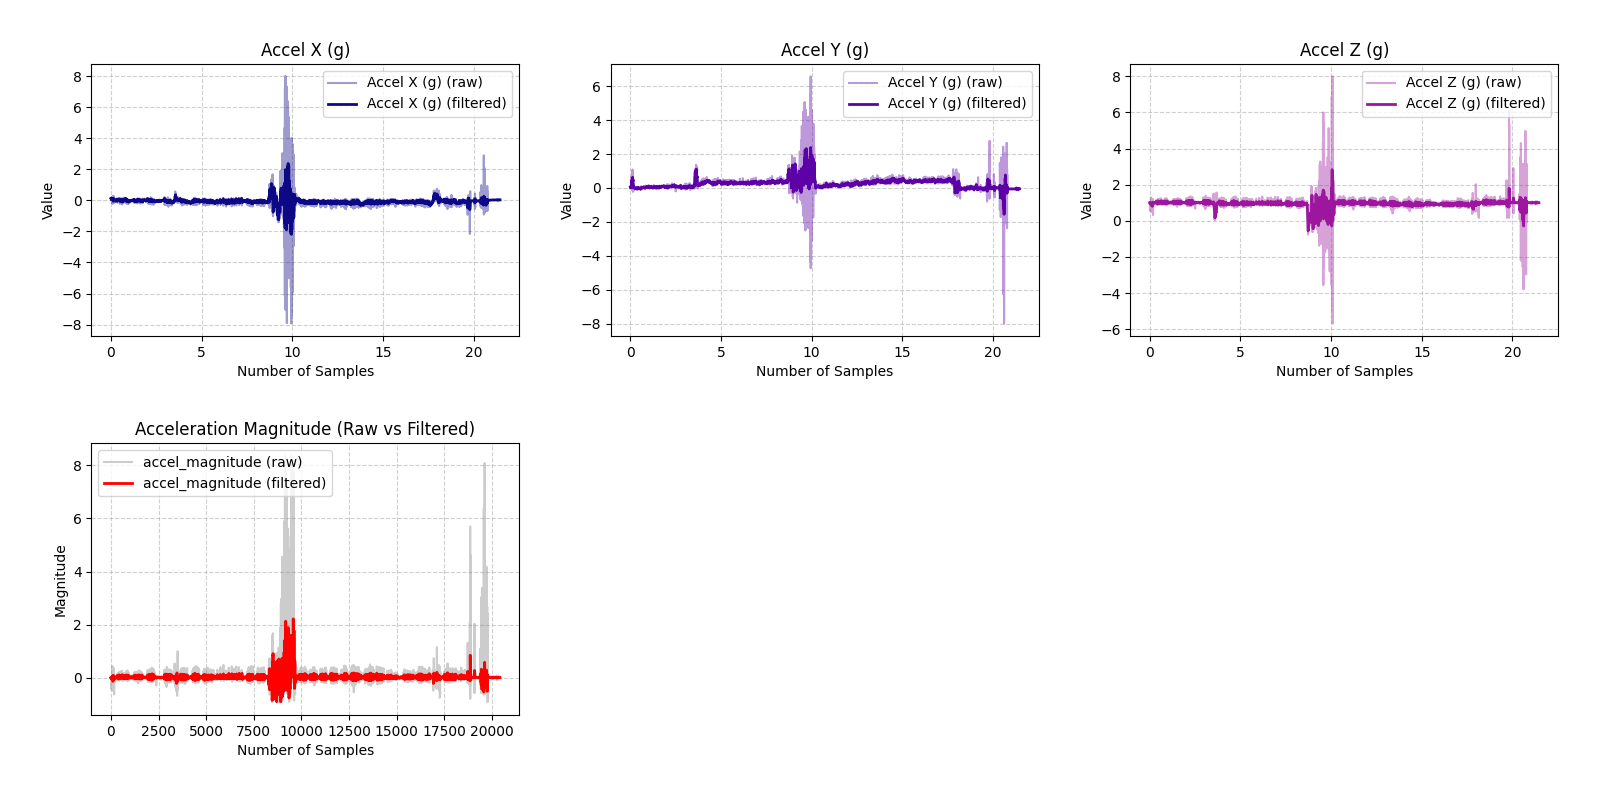

In [4]:
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots (extra row for the magnitude plot)
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False)

# Flatten axes array
axes = axes.flatten()

# --- Top row: your 3 filtered plots ---
for i in range(3):
    ax = axes[i]  # current subplot axis

    # Get data for this subplot
    col = collumn_names[i]  # make sure variable name is correct (not 'collumn_names')
    raw = df[col]
    filtered = df[col + "_lp"]


    # Plot original and filtered signals
    ax.plot(np.arange(len(df)) / 952, raw, label=f"{titles[i]} (raw)", color=plt.cm.plasma(i / 6), alpha=0.4)
    ax.plot(np.arange(len(df)) / 952, filtered, label=f"{titles[i]} (filtered)", color=plt.cm.plasma(i / 6), linewidth=2)

    # Titles, labels, and grid
    ax.set_title(titles[i], fontsize=12)
    ax.set_ylabel("Value")
    ax.set_xlabel("Number of Samples")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

# --- Bottom plot: accel_magnitude vs accel_magnitude_lp ---
ax_mag = axes[3]  # use the next available subplot (bottom-left position)

ax_mag.plot(df['accel_magnitude'], label='accel_magnitude (raw)', color='gray', alpha=0.4)
ax_mag.plot(df['accel_magnitude_lp'], label='accel_magnitude (filtered)', color='red', linewidth=2)

ax_mag.set_title("Acceleration Magnitude (Raw vs Filtered)", fontsize=12)
ax_mag.set_ylabel("Magnitude")
ax_mag.set_xlabel("Number of Samples")
ax_mag.grid(True, linestyle="--", alpha=0.6)
ax_mag.legend()

# Hide any unused subplots (since we have 4 used out of 6)
for j in range(4, 6):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout(pad=3.0)

# Show figure
plt.show()


In [5]:
# Example alpha sizes for SMAs
alpha_sizes = [0.001, 0.01, 0.05, 0.1, 0.5]

# Calculate all SMAs of accel_magnitude_lp with different windows

alpha_signals = []
for a in alpha_sizes:
    ax_lp = exponential_moving_average(df['ax'] , alpha=a)
    ay_lp = exponential_moving_average(df['ay'] , alpha=a)
    az_lp = exponential_moving_average(df['az'] , alpha=a)

    alpha_signals.append(np.sqrt(ax_lp**2 + ay_lp**2 + az_lp**2) - 1)

plt.figure(figsize=(12, 6))

# Plot the original low-pass filtered accel magnitude
plt.plot(df['accel_magnitude_lp'], label='Accel Magnitude LP', linewidth=2, color='black', alpha=0.4)

# Plot each with different alpha sizes
colors = plt.cm.viridis_r(np.linspace(0, 1, len(alpha_sizes)))
for i, (sma, w) in enumerate(zip(alpha_signals, alpha_sizes)):
    plt.plot(sma, label=f'Alpha value={w}', alpha=0.8, color=colors[i])

plt.title('Accel Magnitude LP vs Alpha Exponential Moving Averages')
plt.xlabel('Sample Number')
plt.ylabel('Acceleration (g)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


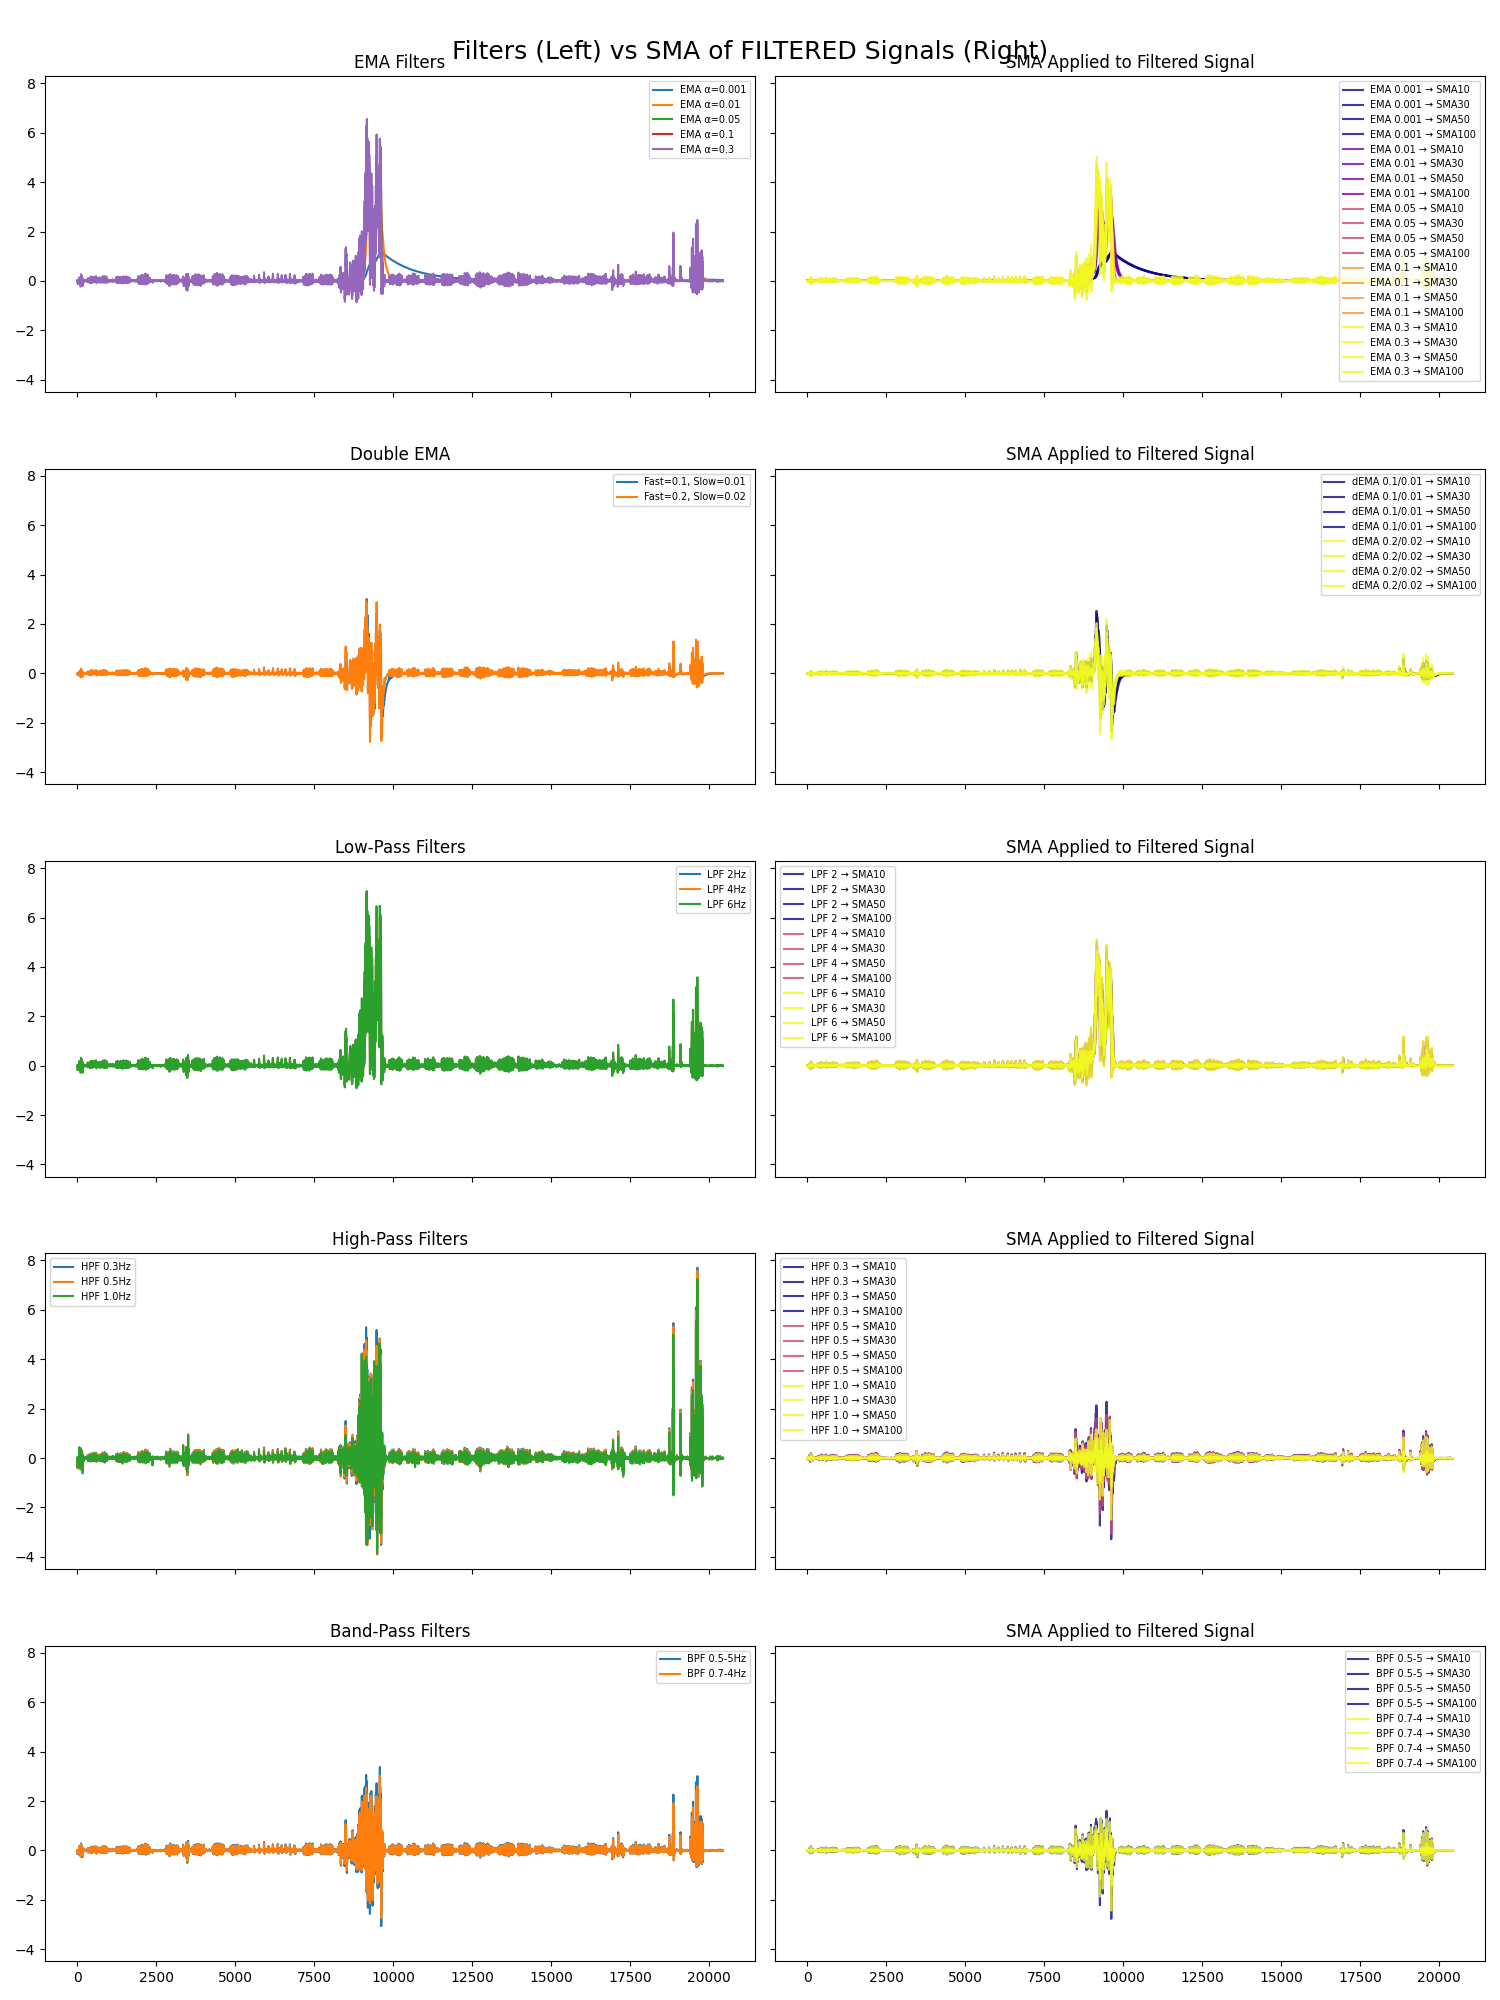

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

# -----------------------------
# Real-time filter definitions
# -----------------------------
def ema_filter(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = y[i-1] + alpha * (x[i] - y[i-1])
    return y

def double_ema(x, alpha_fast, alpha_slow):
    fast = ema_filter(x, alpha_fast)
    slow = ema_filter(x, alpha_slow)
    return fast - slow

def low_pass_filter(x, cutoff, fs):
    dt = 1.0 / fs
    rc = 1.0 / (2*math.pi*cutoff)
    alpha = dt / (rc + dt)
    return ema_filter(x, alpha)

def high_pass_filter(x, cutoff, fs):
    dt = 1.0 / fs
    rc = 1.0 / (2*math.pi*cutoff)
    alpha = rc / (rc + dt)
    y = np.zeros_like(x)
    prev_x = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * (y[i-1] + x[i] - prev_x)
        prev_x = x[i]
    return y

def band_pass_filter(x, low_cut, high_cut, fs):
    hp = high_pass_filter(x, low_cut, fs)
    lp = low_pass_filter(hp, high_cut, fs)
    return lp

# -----------------------------
# Simple Moving Average (SMA)
# -----------------------------
def simple_moving_average(signal, window_size):
    filtered_signal = []
    for i in range(len(signal)):
        start = max(0, i - window_size + 1)
        window = signal[start:i+1]
        filtered_signal.append(sum(window) / len(window))
    return filtered_signal

# -----------------------------
# Prepare magnitude
# -----------------------------
mag = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2) - 1
fs = 50  # sampling rate

# -----------------------------
# Parameters
# -----------------------------
ema_params = [0.001, 0.01, 0.05, 0.1, 0.3]
double_ema_params = [(0.1,0.01), (0.2,0.02)]
lpf_cutoffs = [2, 4, 6]
hpf_cutoffs = [0.3, 0.5, 1.0]
bpf_params = [(0.5,5), (0.7,4)]

sma_windows = [10, 30, 50, 100]  # DIFFERENT windows per row

# -----------------------------
# Figure grid
# -----------------------------
fig, axs = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)
fig.suptitle("Filters (Left) vs SMA of FILTERED Signals (Right)", fontsize=18)

# ======================================================
# Helper: compute SMAs for a list of FILTERED signals
# ======================================================
def plot_smas_of_signals(ax, filtered_list, label_list):
    colors = plt.cm.plasma(np.linspace(0, 1, len(filtered_list)))
    for i, (sig, lbl) in enumerate(zip(filtered_list, label_list)):
        for w in sma_windows:
            sma_sig = simple_moving_average(sig, w)
            ax.plot(sma_sig,
                    alpha=0.8,
                    label=f"{lbl} → SMA{w}",
                    color=colors[i])
    ax.legend(fontsize=7)
    ax.set_title("SMA Applied to Filtered Signal")

# ======================================================
# ROW 1: EMA
# ======================================================
# Left
ema_outputs = [ema_filter(mag, a) for a in ema_params]
for out, a in zip(ema_outputs, ema_params):
    axs[0,0].plot(out, label=f"EMA α={a}")
axs[0,0].set_title("EMA Filters")
axs[0,0].legend(fontsize=7)

# Right (SMA of each EMA output)
plot_smas_of_signals(axs[0,1], ema_outputs, [f"EMA {a}" for a in ema_params])

# ======================================================
# ROW 2: Double EMA
# ======================================================
double_ema_outputs = [double_ema(mag, f, s) for f, s in double_ema_params]
for out, (f,s) in zip(double_ema_outputs, double_ema_params):
    axs[1,0].plot(out, label=f"Fast={f}, Slow={s}")
axs[1,0].set_title("Double EMA")
axs[1,0].legend(fontsize=7)

plot_smas_of_signals(axs[1,1], double_ema_outputs,
                     [f"dEMA {f}/{s}" for f,s in double_ema_params])

# ======================================================
# ROW 3: LPF
# ======================================================
lpf_outputs = [low_pass_filter(mag, c, fs) for c in lpf_cutoffs]
for out, c in zip(lpf_outputs, lpf_cutoffs):
    axs[2,0].plot(out, label=f"LPF {c}Hz")
axs[2,0].set_title("Low-Pass Filters")
axs[2,0].legend(fontsize=7)

plot_smas_of_signals(axs[2,1], lpf_outputs,
                     [f"LPF {c}" for c in lpf_cutoffs])

# ======================================================
# ROW 4: HPF
# ======================================================
hpf_outputs = [high_pass_filter(mag, c, fs) for c in hpf_cutoffs]
for out, c in zip(hpf_outputs, hpf_cutoffs):
    axs[3,0].plot(out, label=f"HPF {c}Hz")
axs[3,0].set_title("High-Pass Filters")
axs[3,0].legend(fontsize=7)

plot_smas_of_signals(axs[3,1], hpf_outputs,
                     [f"HPF {c}" for c in hpf_cutoffs])

# ======================================================
# ROW 5: BPF
# ======================================================
bpf_outputs = [band_pass_filter(mag, lo, hi, fs) for lo,hi in bpf_params]
for out, (lo,hi) in zip(bpf_outputs, bpf_params):
    axs[4,0].plot(out, label=f"BPF {lo}-{hi}Hz")
axs[4,0].set_title("Band-Pass Filters")
axs[4,0].legend(fontsize=7)

plot_smas_of_signals(axs[4,1], bpf_outputs,
                     [f"BPF {lo}-{hi}" for lo,hi in bpf_params])

# -----------------------------
# Final layout
# -----------------------------
plt.tight_layout()
plt.show()


### Second part: Simple moving average

aplicar agora um filtro de media para reduzir mais e termos apenas picos UP-DOWN e nao coisas tipo UP-UP(mas menos intenso) e down

o objetivo é tornar o sinal numa espécie de sinusoide para identificar o pico alto e baixo do step e assim ficar com 3 picos bem definidos no intervalo onde começa e acaba o step 

In [10]:
import matplotlib.pyplot as plt

def simple_moving_average(signal, window_size):
    """Calculates the Simple Moving Average of a signal."""
    filtered_signal = []
    for i in range(len(signal)):
        start_index = max(0, i - window_size + 1)
        window = signal[start_index : i + 1]
        window_average = sum(window) / len(window)
        filtered_signal.append(window_average)
    return filtered_signal


#### Efeito do tamanho da window para a média do sinal

Quanto maior o número de samples menos distorcido e mais bem definido fica o sinal, como seria de esperar, no entanto, maior é a perda de informação do sinal

É necessário encontrar um equilíbro, não só neste parâmetro window_size mas também com a combinação window_size e alpha da exponential moving average.

In [11]:
import matplotlib.pyplot as plt


def simple_moving_average(signal, window_size):
    """Calculates the Simple Moving Average of a signal."""
    filtered_signal = []
    for i in range(len(signal)):
        start_index = max(0, i - window_size + 1)
        window = signal[start_index : i + 1]
        window_average = sum(window) / len(window)
        filtered_signal.append(window_average)
    return filtered_signal

# Example window sizes for SMAs
window_sizes = [5,10, 30, 40, 50, 60, 100]

# Calculate all SMAs of accel_magnitude_lp with different windows
sma_signals = [simple_moving_average(df['accel_magnitude_lp'], w) for w in window_sizes]

plt.figure(figsize=(12, 6))

# Plot the original low-pass filtered accel magnitude
plt.plot(df['accel_magnitude_lp'], label='Accel Magnitude LP', linewidth=2, color='black', alpha=0.4)

# Plot each SMA with different window sizes
colors = plt.cm.viridis_r(np.linspace(0, 1, len(window_sizes)))
for i, (sma, w) in enumerate(zip(sma_signals, window_sizes)):
    plt.plot(sma, label=f'SMA window={w}', alpha=0.8, color=colors[i])

plt.title('Accel Magnitude LP vs Simple Moving Averages')
plt.xlabel('Sample Number')
plt.ylabel('Acceleration (g)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
signal = np.array(simple_moving_average(df['accel_magnitude_lp'], 15))

peaks_pos = []
peaks_neg = []

# We'll keep track of the previous two points to check if the middle one is a peak
# Start iterating from index 2, so we have i-2, i-1, i points for checking peaks
for i in range(2, len(signal)):
    prev2 = signal[i-2]
    prev1 = signal[i-1]
    curr = signal[i]

    # Check if prev1 is a positive peak: goes up then down
    if prev1 > prev2 and prev1 > curr:
        peaks_pos.append(i-1)

    # Check if prev1 is a negative peak: goes down then up
    if prev1 < prev2 and prev1 < curr:
        peaks_neg.append(i-1)

plt.figure(figsize=(12, 6))
plt.plot(signal, label='Filtered Signal')
plt.plot(peaks_pos, signal[peaks_pos], 'ro', label='Positive Peaks')
plt.plot(peaks_neg, signal[peaks_neg], 'bo', label='Negative Peaks')
plt.legend()
plt.grid(True)
plt.show()


# Algoritmo com Máquina de Estados 

## Amplitudes relativas

Se as amplitudes relatives entre picos forem respeitadas pelos limites impostos, e se o intervalo do sinal for maior que o requisito min_peak_interval então um pico é detetado

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def find_step_intervals_by_diff(signal, min_peak_interval, 
                                max1_min_diff_bounds, 
                                max2_min_diff_bounds, 
                                max1_max2_diff_bounds):
    """
    Detects steps based on the amplitude differences between peaks in a
    Max -> Min -> Max sequence.

    Args:
        signal (np.array): The input signal data.
        min_peak_interval (int): The minimum number of samples BETWEEN the first
                                 and second positive peaks of a single step.
        max1_min_diff_bounds (tuple): A (lower, upper) bound for the amplitude
                                      difference between Max Peak 1 and the Min Peak.
        max2_min_diff_bounds (tuple): A (lower, upper) bound for the amplitude
                                      difference between Max Peak 2 and the Min Peak.
        max1_max2_diff_bounds (tuple): A (lower, upper) bound for the absolute
                                       amplitude difference between the two Max Peaks.
    Returns:
        list: A list of detected step intervals in the format [sample_max_peak_1, sample_max_peak_2].
    """
    
    step_intervals = []
    state = "LOOKING_FOR_FIRST_MAX"
    candidate_first_max_index = -1
    candidate_min_index = -1

    i = 1
    while i < len(signal) - 1:
        # --- Check for local maximum (positive peak) ---
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1]:
            if state == "LOOKING_FOR_FIRST_MAX":
                # Any positive peak can start a sequence
                state = "LOOKING_FOR_MIN"
                candidate_first_max_index = i
            
            elif state == "LOOKING_FOR_MIN":
                # Found another max before a min. Assume this new one is a better start.
                candidate_first_max_index = i

            elif state == "LOOKING_FOR_SECOND_MAX":
                # --- This is where all validation now happens ---
                max1_val = signal[candidate_first_max_index]
                min_val = signal[candidate_min_index]
                max2_val = signal[i]

                # Calculate the differences
                diff_max1_min = max1_val - min_val
                diff_max2_min = max2_val - min_val
                diff_max1_max2 = abs(max1_val - max2_val) # Absolute difference is more robust
                interval_width = i - candidate_first_max_index

                # --- Check all conditions against their bounds ---
                is_wide_enough = interval_width >= min_peak_interval
                is_max1_min_valid = max1_min_diff_bounds[0] <= diff_max1_min <= max1_min_diff_bounds[1]
                is_max2_min_valid = max2_min_diff_bounds[0] <= diff_max2_min <= max2_min_diff_bounds[1]
                is_max1_max2_valid = max1_max2_diff_bounds[0] <= diff_max1_max2 <= max1_max2_diff_bounds[1]

                if is_wide_enough and is_max1_min_valid and is_max2_min_valid and is_max1_max2_valid:
                    # SUCCESS: The step is valid.
                    step_intervals.append([candidate_first_max_index, i])
                    # Chain the logic: this peak is now the start of the next potential step.
                    state = "LOOKING_FOR_MIN" 
                    candidate_first_max_index = i
                else:
                    # Sequence failed validation. Use this peak as a new potential start.
                    state = "LOOKING_FOR_MIN"
                    candidate_first_max_index = i

        # --- Check for local minimum (negative peak) ---
        if signal[i] < signal[i - 1] and signal[i] < signal[i + 1]:
            if state == "LOOKING_FOR_MIN":
                # Found the valley, now look for the final peak
                state = "LOOKING_FOR_SECOND_MAX"
                candidate_min_index = i
        
        i += 1
        
    return step_intervals


### Hyper tuning parameters

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the recorded data and your manual sample numbers
sensor_data = pd.read_csv("../data/sensor_data.csv")
manual_steps = pd.read_csv("../data/manual_step_samples.csv")

# This will give you a list of detected step *indices*, which is exactly what you need.
# For example:
# detected_step_indices = [150, 220, 285, ...] 

sensor_data['ax_lp'] = exponential_moving_average(sensor_data['ax'] , alpha=alpha)
sensor_data['ay_lp'] = exponential_moving_average(sensor_data['ay'] , alpha=alpha)
sensor_data['az_lp'] = exponential_moving_average(sensor_data['az'] , alpha=alpha)

sensor_data['accel_magnitude_lp'] = np.sqrt(sensor_data['ax_lp']**2 + sensor_data['ay_lp']**2 + sensor_data['az_lp']**2) - 1
sensor_data['accel_magnitude'] = np.sqrt(sensor_data['ax']**2 + sensor_data['ay']**2 + sensor_data['az']**2) - 1

signal = np.array(simple_moving_average(sensor_data['accel_magnitude_lp'], optimal_w))

plt.figure(figsize=(14, 7))
plt.plot(signal, label='Processed Accel Signal',color='red')
plt.plot(sensor_data['accel_magnitude'], label='Raw Accel Signal', color='gray')

# Plot the manual steps as vertical lines at the recorded sample numbers
for sample_num in manual_steps['sample_number']:
    plt.axvline(x=sample_num, color='g', linestyle='--', linewidth=2, label='Manual Step (Ground Truth)')


plt.title("Algorithm Verification (Sample-Based)")
plt.xlabel("Sample Number")
plt.grid(True)
plt.show()

NameError: name 'optimal_w' is not defined

Detected 4 steps.
Intervals [Max Peak 1, Max Peak 2]:


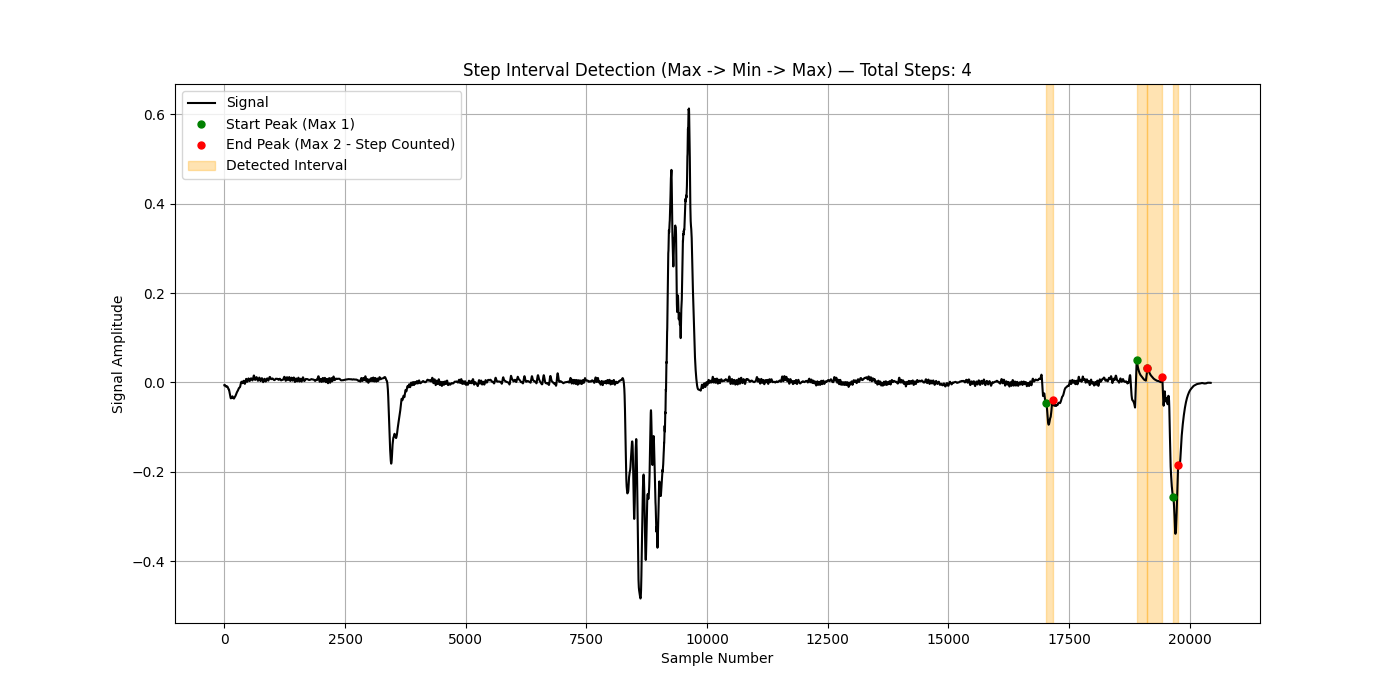

In [ ]:
# 3. Call the new function
detected_intervals = find_step_intervals_by_diff(
    signal=signal,
    min_peak_interval=74,
    max1_min_diff_bounds=(0.0214, 0.1546),
    max2_min_diff_bounds=(0, 0.6653),
    max1_max2_diff_bounds=(0, 0.6557)
)


# 4. Print the output
print(f"Detected {len(detected_intervals)} steps.")
print("Intervals [Max Peak 1, Max Peak 2]:")

# 5. (Optional) Plot the results to verify
plt.figure(figsize=(14, 7))
plt.plot(signal, label='Signal', color='black')

# Unzip the intervals and plot the start and end peaks
if detected_intervals:
    max_peaks_1, max_peaks_2 = zip(*detected_intervals)
    plt.plot(max_peaks_1, signal[list(max_peaks_1)], 'go', markersize=5, label='Start Peak (Max 1)')
    plt.plot(max_peaks_2, signal[list(max_peaks_2)], 'ro', markersize=5, label='End Peak (Max 2 - Step Counted)')
    
    # Shade the area for each detected step interval
    for i, interval in enumerate(detected_intervals):
        label = 'Detected Interval' if i == 0 else ""
        plt.axvspan(interval[0], interval[1], color='orange', alpha=0.3, label=label)


plt.title(f'Step Interval Detection (Max -> Min -> Max) — Total Steps: {len(detected_intervals)}')
plt.xlabel('Sample Number')
plt.ylabel('Signal Amplitude')
plt.grid(True)
plt.legend()
plt.show()

### Testando Accuracy

--- Algorithm Performance ---
Manual Steps Found (True Positives): 0 / 257
Manual Steps Missed (False Negatives): 257
Extra Detections (False Positives): 4


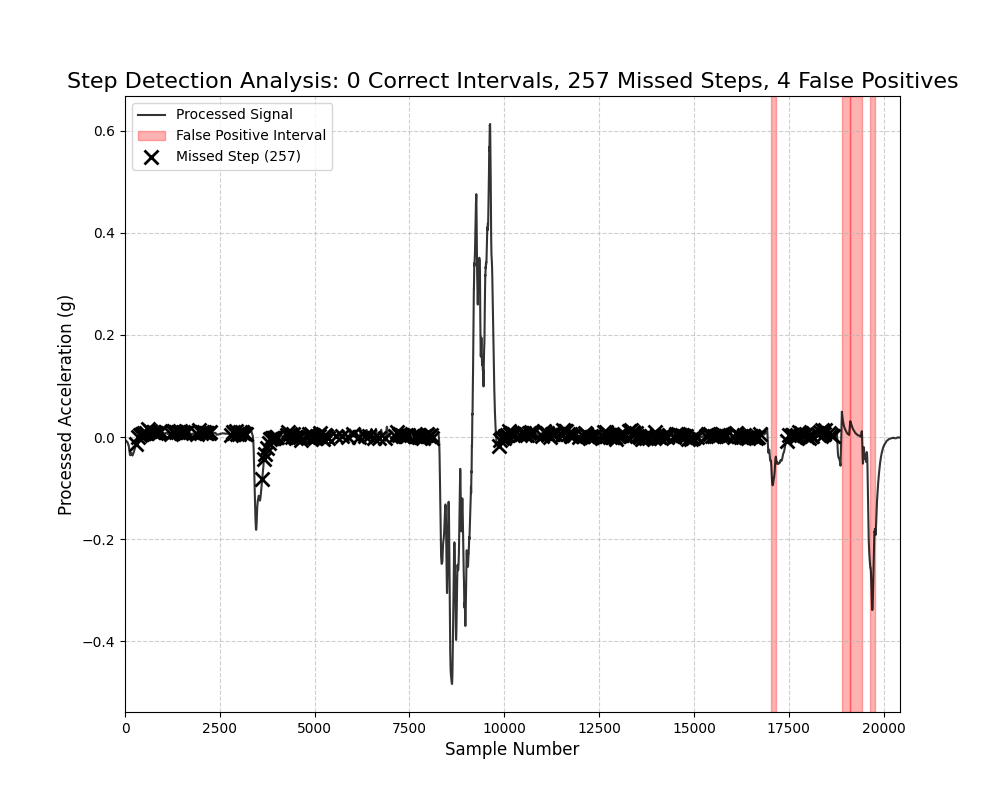

In [ ]:
# =================================================================
# 3. COMPARISON LOGIC
# =================================================================
manual_steps_arr = manual_steps['sample_number'].to_numpy()
is_manual_step_detected = np.zeros(len(manual_steps_arr), dtype=bool)
is_interval_a_true_positive = np.zeros(len(detected_intervals), dtype=bool)

for i, manual_sample in enumerate(manual_steps_arr):
    for j, interval in enumerate(detected_intervals):
        start_peak_index, end_peak_index = interval
        if start_peak_index <= manual_sample <= end_peak_index:
            is_manual_step_detected[i] = True
            is_interval_a_true_positive[j] = True
            # We don't break here, allowing one interval to potentially cover two close manual steps

# Categorize everything
missed_steps = manual_steps_arr[~is_manual_step_detected]
true_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if is_interval_a_true_positive[i]]
false_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if not is_interval_a_true_positive[i]]

print("--- Algorithm Performance ---")
print(f"Manual Steps Found (True Positives): {np.sum(is_manual_step_detected)} / {len(manual_steps_arr)}")
print(f"Manual Steps Missed (False Negatives): {len(missed_steps)}")
print(f"Extra Detections (False Positives): {len(false_positive_intervals)}")

# =================================================================
# 4. PLOTTING
# =================================================================
plt.figure(figsize=(10, 8))

# --- Plot the main signal ---
plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)

# --- Plot the results using shaded areas ---
# True Positives (Green shaded areas)
for i, interval in enumerate(true_positive_intervals):
    label = 'True Positive Interval' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='green', alpha=0.3, label=label, zorder=1)

# False Positives (Red shaded areas)
for i, interval in enumerate(false_positive_intervals):
    label = 'False Positive Interval' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='red', alpha=0.3, label=label, zorder=1)

# Missed Steps (Black 'X' markers)
if len(missed_steps) > 0:
    plt.plot(missed_steps, signal[missed_steps], 'kx', markersize=10, mew=2, label=f'Missed Step ({len(missed_steps)})', zorder=5)

# --- Final Touches ---
title = f"Step Detection Analysis: {len(true_positive_intervals)} Correct Intervals, {len(missed_steps)} Missed Steps, {len(false_positive_intervals)} False Positives"
plt.title(title, fontsize=16)
plt.xlabel("Sample Number", fontsize=12)
plt.ylabel("Processed Acceleration (g)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, len(sensor_data))
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def test_accuracy(detected_intervals, manual_steps_df, verbose=False):
    """
    Calculates and visualizes the performance of a step detection algorithm.

    This function compares the intervals found by an algorithm against a list of
    manually-recorded "ground truth" steps. It calculates performance metrics
    (Precision, Recall, F1-Score) and generates a plot that clearly distinguishes
    between true positives, false positives, and false negatives.

    Args:
        detected_intervals (list): The list of [start, end] intervals returned
                                   by the step detection algorithm.
        manual_steps_df (pd.DataFrame): A DataFrame loaded from your CSV,
                                        containing a 'sample_number' column.
    
    Returns:
        dict: A dictionary containing the calculated performance metrics.
    """
    
    # =================================================================
    # 1. COMPARISON LOGIC
    # =================================================================
    manual_steps_arr = manual_steps_df['sample_number'].to_numpy()
    
    # Boolean flags to track matches
    is_manual_step_detected = np.zeros(len(manual_steps_arr), dtype=bool)
    is_interval_a_true_positive = np.zeros(len(detected_intervals), dtype=bool)

    # Iterate through each manual step to see if it was found
    for i, manual_sample in enumerate(manual_steps_arr):
        for j, interval in enumerate(detected_intervals):
            start_peak_index, end_peak_index = interval
            # Check if the manual step falls within the detected interval
            if start_peak_index <= manual_sample <= end_peak_index:
                is_manual_step_detected[i] = True
                is_interval_a_true_positive[j] = True
                break # A manual step can only be found once

    # --- Calculate performance metrics ---
    true_positives = np.sum(is_manual_step_detected)
    false_negatives = len(manual_steps_arr) - true_positives
    false_positives = len(detected_intervals) - np.sum(is_interval_a_true_positive)
    
    # Precision: Of all the steps we detected, how many were real?
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    # Recall: Of all the real steps that exist, how many did we find?
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    # F1-Score: The harmonic mean of Precision and Recall. A single great score.
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    if verbose:
        print("--- Algorithm Performance Report ---")
        print(f"Manual Steps Found (True Positives):   {true_positives} / {len(manual_steps_arr)}")
        print(f"Manual Steps Missed (False Negatives): {false_negatives}")
        print(f"Extra Detections (False Positives):    {false_positives}")
        print("-" * 36)
        print(f"Precision: {precision:.2%}")
        print(f"Recall:    {recall:.2%}")
        print(f"F1-Score:  {f1_score:.4f}")
        print("-" * 36)
    
    return {
        'true_positives': true_positives,
        'false_negatives': false_negatives,
        'false_positives': false_positives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }


# 4. Call the new function to get the full performance analysis
performance_metrics = test_accuracy(detected_intervals, manual_steps)
print(performance_metrics)

{'true_positives': np.int64(0), 'false_negatives': np.int64(257), 'false_positives': np.int64(4), 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1_score': 0}


In [ ]:
import pandas as pd
import numpy as np
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

space  = [
    Integer(10, 500, name='optimal_w'),
    Real(0.01, 0.5, name='alpha'),
    Integer(10, 500, name='min_peak_interval'),
    # Bounds for Max1-Min difference
    Real(0, 0.8, name='max1_min_lower'),
    Real(0, 0.8, name='max1_min_delta'), # USA SE DELTA POI SÉ MAIS FACIL SE DEFINISSE UUM UPPER TINHA Q INICIALIZARA CONSOANTE O LOWER PARA RESPEITAR BOUND
    # Bounds for Max2-Min difference
    Real(0, 0.8, name='max2_min_lower'),
    Real(0, 0.8, name='max2_min_delta'),
    # Bounds for Max1-Max2 difference
    Real(0, 0.8, name='max1_max2_lower'),
    Real(0, 0.8, name='max1_max2_delta'),
]


# --- NEW: Caching dictionary to speed up EMA calculations ---
ema_cache = {}

# --- NEW: Updated Objective Function ---
@use_named_args(space)
def objective(**params):
    """
    NOW, this function recalculates the signal for each run using the
    provided alpha and optimal_w.
    """
    alpha = params['alpha']
    optimal_w = params['optimal_w']

    # --- Caching logic for efficiency ---
    if alpha not in ema_cache:
        # If we haven't seen this alpha before, calculate and store the EMA result
        ax_lp = exponential_moving_average(sensor_data['ax'], alpha)
        ay_lp = exponential_moving_average(sensor_data['ay'], alpha)
        az_lp = exponential_moving_average(sensor_data['az'], alpha)
        accel_mag_lp = np.sqrt(np.square(ax_lp) + np.square(ay_lp) + np.square(az_lp)) - 1.0
        ema_cache[alpha] = accel_mag_lp
    
    # Retrieve the (possibly cached) EMA result
    accel_magnitude_lp = ema_cache[alpha]

    # --- Generate the final signal for this run ---
    signal = simple_moving_average(accel_magnitude_lp, optimal_w)
    
    # --- Reconstruct the bounds for the detection algorithm ---
    max1_min_b = (params['max1_min_lower'], params['max1_min_lower'] + params['max1_min_delta'])
    max2_min_b = (params['max2_min_lower'], params['max2_min_lower'] + params['max2_min_delta'])
    max1_max2_b = (params['max1_max2_lower'], params['max1_max2_lower'] + params['max1_max2_delta'])

    # Run the core algorithm on the newly generated signal
    detected_intervals = find_step_intervals_by_diff(
        signal=signal,
        min_peak_interval=params['min_peak_interval'],
        max1_min_diff_bounds=max1_min_b,
        max2_min_diff_bounds=max2_min_b,
        max1_max2_diff_bounds=max1_max2_b
    )
    
    f1 = test_accuracy(detected_intervals, manual_steps)['f1_score']
    return 1.0 - f1


# 2. Run the Bayesian Optimization
# n_calls is your "budget" for how many combinations to test.
print("Starting Bayesian Optimization to find the best parameters...")
start_time = time.time()


initial_params = [
    # [np.int64(100), 0.06748036004974223, np.int64(100), 0.004141875561478496, 0.4090256644585729, 0.018514232057777035, 0.378782748614783, 0.0, 0.6275043927369609]
    # [np.int64(130), 0.03, np.int64(81), 0.0, 0.607802698857589, 0.0, 0.6888716620101909, 0.0, 0.8],
    # [np.int64(82), 0.011286980668246436, np.int64(74), 0.02143678646509661, 0.15463255015788627, 0.0, 0.6652631489832426, 0.0, 0.655675569896947]
]

result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=300,       # Total number of combinations to test
    random_state=42,
    # x0=initial_params,
    verbose=True,
    n_jobs=-1
)

end_time = time.time()
print(f"\nOptimization complete in {end_time - start_time:.2f} seconds.")

# 3. Present the best results
best_f1_score = 1.0 - result.fun
best_parameters = result.x

# Map the parameter list back to names for readability
best_params_dict = {param.name: value for param, value in zip(space, best_parameters)}

print("\n" + "="*50)
print("           BEST PARAMETERS FOUND")
print("="*50)
print(f"\nBest F1-Score: {best_f1_score:.4f}")
print("Optimal Parameters:")
for name, value in best_params_dict.items():
    if isinstance(value, float):
        print(f"  - {name}: {value:.4f}")
    else:
        print(f"  - {name}: {value}")


print(best_params_dict.values())

Starting Bayesian Optimization to find the best parameters...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3644
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2189
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 3 started. Evaluating function at random point.


KeyboardInterrupt: 

### Plot best result

In [ ]:
alpha = best_params_dict['alpha']
optimal_w = best_params_dict['optimal_w']

accel_magnitude_lp = ema_cache[alpha]
signal_best = simple_moving_average(accel_magnitude_lp, optimal_w)

max1_min_b = (best_params_dict['max1_min_lower'], best_params_dict['max1_min_lower'] + best_params_dict['max1_min_delta'])
max2_min_b = (best_params_dict['max2_min_lower'], best_params_dict['max2_min_lower'] + best_params_dict['max2_min_delta'])
max1_max2_b = (best_params_dict['max1_max2_lower'], best_params_dict['max1_max2_lower'] + best_params_dict['max1_max2_delta'])

detected_intervals = find_step_intervals_by_diff(
    signal=signal_best,
    min_peak_interval=best_params_dict['min_peak_interval'],
    max1_min_diff_bounds=max1_min_b,
    max2_min_diff_bounds=max2_min_b,
    max1_max2_diff_bounds=max1_max2_b
)

test_accuracy(detected_intervals, manual_steps, verbose=True) # 78/86/82.55

--- Algorithm Performance Report ---
Manual Steps Found (True Positives):   74 / 80
Manual Steps Missed (False Negatives): 6
Extra Detections (False Positives):    9
------------------------------------
Precision: 89.16%
Recall:    92.50%
F1-Score:  0.9080
------------------------------------


{'true_positives': np.int64(74),
 'false_negatives': np.int64(6),
 'false_positives': np.int64(9),
 'precision': np.float64(0.891566265060241),
 'recall': np.float64(0.925),
 'f1_score': np.float64(0.9079754601226994)}

In [ ]:
def plot_best_result(signal, manual_steps_df, best_params):
    """
    Takes the best parameters, runs the algorithm, and generates a
    detailed performance plot.

    Args:
        signal (np.array): The processed signal that was analyzed.
        manual_steps_df (pd.DataFrame): DataFrame with 'sample_number' column.
        best_params (dict): Dictionary of the best parameters found by the optimizer.
    """
    print("\n" + "="*55)
    print("         VISUALIZING THE BEST PARAMETER SET")
    print("="*55)

    signal = np.asarray(signal)

    # --- 1. Reconstruct the bounds from the best parameters ---
    m1m_lower = best_params['max1_min_lower']
    m1m_upper = m1m_lower + best_params['max1_min_delta']
    max1_min_b = (m1m_lower, m1m_upper)

    m2m_lower = best_params['max2_min_lower']
    m2m_upper = m2m_lower + best_params['max2_min_delta']
    max2_min_b = (m2m_lower, m2m_upper)
    
    m1m2_lower = best_params['max1_max2_lower']
    m1m2_upper = m1m2_lower + best_params['max1_max2_delta']
    max1_max2_b = (m1m2_lower, m1m2_upper)

    # --- 2. Run the detection algorithm with the optimal parameters ---
    print("\nRunning final detection with the best parameters...")
    detected_intervals = find_step_intervals_by_diff(
        signal=signal,
        min_peak_interval=best_params['min_peak_interval'],
        max1_min_diff_bounds=max1_min_b,
        max2_min_diff_bounds=max2_min_b,
        max1_max2_diff_bounds=max1_max2_b
    )

    # --- 3. Perform the comparison logic ---
    manual_steps_arr = manual_steps_df['sample_number'].to_numpy()
    is_manual_step_detected = np.zeros(len(manual_steps_arr), dtype=bool)
    is_interval_a_true_positive = np.zeros(len(detected_intervals), dtype=bool)

    for i, manual_sample in enumerate(manual_steps_arr):
        for j, interval in enumerate(detected_intervals):
            if interval[0] <= manual_sample <= interval[1]:
                is_manual_step_detected[i] = True
                is_interval_a_true_positive[j] = True
                break
    
    true_positives = np.sum(is_manual_step_detected)
    false_negatives = len(manual_steps_arr) - true_positives
    false_positives = len(detected_intervals) - np.sum(is_interval_a_true_positive)
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n--- Final Performance Report ---")
    print(f"F1-Score: {f1_score:.4f} (Precision: {precision:.2%}, Recall: {recall:.2%})")
    print(f"  - Correctly Detected: {true_positives}")
    print(f"  - Missed Steps:       {false_negatives}")
    print(f"  - False Detections:   {false_positives}")

    # --- 4. Generate the detailed plot ---
    true_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if is_interval_a_true_positive[i]]
    false_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if not is_interval_a_true_positive[i]]
    missed_steps = manual_steps_arr[~is_manual_step_detected]

    plt.figure(figsize=(12, 8))
    plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)

    # Plot True Positives (Green shaded areas)
    for i, interval in enumerate(true_positive_intervals):
        label = 'True Positive Interval' if i == 0 else ""
        plt.axvspan(interval[0], interval[1], color='green', alpha=0.4, label=label, zorder=1)

    # Plot False Positives (Red shaded areas)
    for i, interval in enumerate(false_positive_intervals):
        label = 'False Positive Interval' if i == 0 else ""
        plt.axvspan(interval[0], interval[1], color='red', alpha=0.4, label=label, zorder=1)

    # Plot Missed Steps (Black 'X' markers)
    valid_missed = missed_steps[missed_steps < len(signal)]

    if len(valid_missed) > 0:
        plt.plot(valid_missed, signal[valid_missed], 'kx', markersize=12, mew=2, label='Missed Step', zorder=5)

    title = f"Final Performance with Optimal Parameters (F1-Score: {f1_score:.4f})"
    plt.title(title, fontsize=16)
    plt.xlabel("Sample Number", fontsize=12)
    plt.ylabel("Processed Acceleration (g)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, len(signal))
    plt.show()


plot_best_result(signal_best, manual_steps, best_params_dict)


NameError: name 'signal_best' is not defined

## Neural Networks :)

Calcular todos os intervalos que podem ser um possível step, isto é sequências de Picos Max->min->Max, obter features, e alimentar neural network com essas features

In [14]:
import pandas as pd

# Load files
sensor_data1 = pd.read_csv("../data/sensor_data.csv")
manual_steps1 = pd.read_csv("../data/manual_step_samples.csv")

sensor_data2 = pd.read_csv("../data/xico1_sensor_data.csv")
manual_steps2 = pd.read_csv("../data/xico1_manual_step_samples.csv")

# --- Step 1: Get the length of the first sensor dataset ---
len1 = len(sensor_data1)

# --- Step 2: Shift manual step sample numbers from dataset 2 ---
manual_steps2_shifted = manual_steps2.copy()
manual_steps2_shifted["sample_number"] = manual_steps2["sample_number"] + len1

# --- Step 3: Concatenate sensor data ---
sensor_data = pd.concat([sensor_data1, sensor_data2], ignore_index=True)

# --- Step 4: Concatenate manual step labels ---
manual_steps = pd.concat([manual_steps1, manual_steps2_shifted], ignore_index=True)

# (optional) sort manual steps just in case
manual_steps = manual_steps.sort_values("sample_number").reset_index(drop=True)

print("Merged sensor data length:", len(sensor_data))
print("Merged manual steps length:", len(manual_steps))

Merged sensor data length: 33851
Merged manual steps length: 403


### Obter Features

In [14]:
import numpy as np
import pandas as pd

manual_steps_list = manual_steps['sample_number'].to_numpy()

def extract_and_label_features_by_containment(signal, manual_step_samples):
    """Extracts 15 features per interval."""
    features = []
    labels = []
    detected_intervals = []
    
    state = "LOOKING_FOR_FIRST_MAX"
    max1_idx = -1
    min_idx = -1

    for i in range(1, len(signal) - 1):
        # Local Max
        if signal[i] > signal[i-1] and signal[i] > signal[i+1]:
            if state == "LOOKING_FOR_FIRST_MAX":
                state = "LOOKING_FOR_MIN"
                max1_idx = i
            elif state == "LOOKING_FOR_MIN":
                max1_idx = i
            elif state == "LOOKING_FOR_SECOND_MAX":
                max2_idx = i
                
                # Extract Features
                interval_slice = signal[max1_idx:max2_idx+1]
                duration = max2_idx - max1_idx
                
                if duration > 0:
                    val_max1 = signal[max1_idx]
                    val_min = signal[min_idx]
                    val_max2 = signal[max2_idx]
                    t1 = min_idx - max1_idx
                    t2 = max2_idx - min_idx
                    
                    # 15 Features vector
                    f_vec = [
                        val_max1, val_min, val_max2,
                        val_max1 - val_min, val_max2 - val_min, abs(val_max1 - val_max2),
                        (val_max1 - val_min)/t1, 
                        (val_max2 - val_min)/t2,
                        t1/duration, t2/duration, duration
                    ]
                    
                    features.append(f_vec)
                    detected_intervals.append([max1_idx, max2_idx])
                    
                    # Labeling (Containment)
                    is_step = any(max1_idx <= ms <= max2_idx for ms in manual_step_samples)
                    labels.append(1 if is_step else 0)

                state = "LOOKING_FOR_MIN"
                max1_idx = i

        # Local Min
        if signal[i] < signal[i-1] and signal[i] < signal[i+1]:
            if state == "LOOKING_FOR_MIN":
                state = "LOOKING_FOR_SECOND_MAX"
                min_idx = i

    return np.array(features), np.array(labels), np.array(detected_intervals)

### Treinar Random Forests para encontrar melhores parâmetros

além de que é mais eficiente treinar RF do que NN com otimização bayesiana

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- Optimizer Imports ---
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Define Search Space
search_space = [
    Integer(1, 30, name='optimal_w'),
    Real(0.05, 1, name='alpha')
]

ema_cache = {}   # Cache for EMA signals


@use_named_args(search_space)
def objective(optimal_w, alpha):
    """Objective function with Stratified K-Fold Cross Validation."""
    # ------------------------------------------------------------
    # 1) PREPROCESS SIGNAL (EMA + SMA) WITH CACHING
    # ------------------------------------------------------------
    alpha_key = f"{alpha:.6f}"

    # EMA caching for speed
    if alpha_key not in ema_cache:
        ax_lp = exponential_moving_average(sensor_data['ax'].values, alpha)
        ay_lp = exponential_moving_average(sensor_data['ay'].values, alpha)
        az_lp = exponential_moving_average(sensor_data['az'].values, alpha)

        mag = np.sqrt(ax_lp**2 + ay_lp**2 + az_lp**2) - 1.0
        ema_cache[alpha_key] = mag

    signal = simple_moving_average(ema_cache[alpha_key], optimal_w)

    # ------------------------------------------------------------
    # 2) EXTRACT FEATURES
    # ------------------------------------------------------------
    X, y, _ = extract_and_label_features_by_containment(signal, manual_steps_list)

    if len(X) < 50 or len(np.unique(y)) < 2:
        return 1.0  # return worst score if invalid

    X = np.array(X)
    y = np.array(y)

    # ------------------------------------------------------------
    # 3) STRATIFIED K-FOLD VALIDATION
    # ------------------------------------------------------------
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []

    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fast model for scoring
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        )
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)

        f1_scores.append(f1_score(y_test, preds, zero_division=0))

    # ------------------------------------------------------------
    # 4) RETURN THE METRIC TO MINIMIZE
    # ------------------------------------------------------------
    mean_f1 = np.mean(f1_scores)
    return 1.0 - mean_f1   # minimize (1 - F1)


# =============================================================
# 4) RUN BAYESIAN OPTIMIZATION
# =============================================================
print("--- Starting Bayesian Optimization (Cross-Validated w & α) ---")
start_t = time.time()

result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=200,
    random_state=42,
    verbose=True
)

print(f"\nOptimization completed in {time.time() - start_t:.1f}s")
best_w = result.x[0]
best_alpha = result.x[1]

print(f"BEST PARAMETERS FOUND:")
print(f"→ w = {best_w}")
print(f"→ alpha = {best_alpha:.4f}")


2025-11-24 12:29:33.259989: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 12:29:33.516046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 12:29:35.199800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


--- Starting Bayesian Optimization (Cross-Validated w & α) ---
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6154
Function value obtained: 0.0924
Current minimum: 0.0924
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6452
Function value obtained: 0.1352
Current minimum: 0.0924
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6211
Function value obtained: 0.0682
Current minimum: 0.0682
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6431
Function value obtained: 0.1277
Current minimum: 0.0682
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.6262
Function value obtained: 0.2

/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(12), 0.05] before, using random point [np.int64(3), 0.4317529928937901]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.8534
Function value obtained: 0.2703
Current minimum: 0.0627
Iteration No: 25 started. Searching for the next optimal point.


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(12), 0.05] before, using random point [np.int64(15), 0.4343900902185604]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.8823
Function value obtained: 0.1470
Current minimum: 0.0627
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7847
Function value obtained: 0.0649
Current minimum: 0.0627
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7961
Function value obtained: 0.0823
Current minimum: 0.0627
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.8083
Function value obtained: 0.1293
Current minimum: 0.0627
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7204
Function value obtained: 0.0715
Current minimum: 0.0627
Iteration No: 30 started. Sea

### Treinar NN Modelo Final

In [ ]:
from sklearn.model_selection import train_test_split


print("\n--- Training Final Neural Network with Best Parameters ---")

# 1. Re-generate best signal
ax_lp = exponential_moving_average(sensor_data['ax'].values, best_alpha)
ay_lp = exponential_moving_average(sensor_data['ay'].values, best_alpha)
az_lp = exponential_moving_average(sensor_data['az'].values, best_alpha)
mag = np.sqrt(ax_lp**2 + ay_lp**2 + az_lp**2) - 1.0
best_signal = simple_moving_average(mag, best_w)

# 2. Extract Data
X, y, intervals = extract_and_label_features_by_containment(best_signal, manual_steps_list)

# 3. Split & Scale (Neural Nets NEED Scaling)
X_train, X_test, y_train, y_test, int_train, int_test = train_test_split(
    X, y, intervals, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Build Model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate weights because we didn't clean the data
neg = len(y_train) - sum(y_train)
pos = sum(y_train)
ratio = neg / pos if pos > 0 else 1.0
weights = {0: 1.0, 1: min(ratio, 3.0)} # Cap weight at 3.0 to prevent False Positive explosion

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    class_weight=weights,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

print("Neural Network Training Complete.")


--- Training Final Neural Network with Best Parameters ---


NameError: name 'train_test_split' is not defined

### Estatisticas

In [60]:
# Predict
y_probs = model.predict(X_test).flatten()
# Optional: Find best threshold (usually 0.5 is fine if model is good)
y_pred = (y_probs > 0.5).astype(int)

# Stats
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

print("\n" + "="*40)
print("       FINAL RESULTS")
print("="*40)
print(f"Accuracy:  {(tp+tn)/len(y_test):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print("-" * 20)
print(f"True Steps Found (TP):      {tp}")
print(f"True Steps Missed (FN):     {fn}")
print(f"False Alarms (FP):          {fp}")
print("-" * 20)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Noise', 'Step']))

# --- PLOT ---
plt.figure(figsize=(15, 6))
plt.plot(best_signal, color='black', alpha=0.3, label='Processed Signal')

# Limit plotting to first 500 test intervals to keep plot readable
plot_limit = min(len(int_test), 500)
print(f"Visualizing first {plot_limit} test intervals...")

for i in range(plot_limit):
    start, end = int_test[i]
    pred = y_pred[i]
    truth = y_test[i]
    
    if pred == 1 and truth == 1:
        color = 'green' # TP
        alpha = 0.4
    elif pred == 1 and truth == 0:
        color = 'orange' # FP
        alpha = 0.5
    elif pred == 0 and truth == 1:
        color = 'red' # FN (Missed)
        alpha = 0.5
    else:
        continue 

    plt.axvspan(start, end, color=color, alpha=alpha)

# plt.plot(manual_steps_list, best_signal[manual_steps_list], 'bx', label='Manual Label')
plt.title(f"NN Results (w={best_w}, alpha={best_alpha:.4f}): Green=Good, Orange=FalsePos, Red=Missed")
plt.legend(loc='upper right')

# Zoom roughly to test area
if len(int_test) > 0:
    plt.xlim(int_test[:,0].min() - 200, int_test[:,1].max() + 200)

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

       FINAL RESULTS
Accuracy:  0.9550
F1 Score:  0.9383
--------------------
True Steps Found (TP):      76
True Steps Missed (FN):     4
False Alarms (FP):          6
--------------------

Classification Report:
              precision    recall  f1-score   support

       Noise       0.97      0.96      0.96       142
        Step       0.93      0.95      0.94        80

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.96      0.95      0.96       222

Visualizing first 222 test intervals...


In [61]:
X, y, intervals = extract_and_label_features_by_containment(best_signal, manual_steps_list)

# --- STEP 1: APPLY SCALER ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Train on SCALED data

# 2. Build Model
model = Sequential([
    Input(shape=(X_scaled.shape[1],)), # Input shape matches scaled data
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Weights logic
neg = len(y) - sum(y)
pos = sum(y)
ratio = neg / pos if pos > 0 else 1.0
weights = {0: 1.0, 1: min(ratio, 3.0)} 

# Train on X_scaled
history = model.fit(
    X_scaled, y,
    epochs=100,
    batch_size=32,
    class_weight=weights,
    validation_split=0.2, # Note: random split on time-series is risky, but acceptable for this stage
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

# --- STEP 2: EXPORT SCALER CONSTANTS ---
print("// COPY THIS TO StepDetector.cpp TOP")
print(f"const float SCALER_MEANS[{X.shape[1]}] = {{ " + ", ".join([f"{x:.6f}f" for x in scaler.mean_]) + " };")
print(f"const float SCALER_STDS[{X.shape[1]}] = {{ " + ", ".join([f"{x:.6f}f" for x in scaler.scale_]) + " };")
print("\n")


layer_index = 0

def format_cpp_array(name, array):
    array = np.array(array)
    if array.ndim == 1:
        # Bias vector
        s = f"static const float {name}[{array.shape[0]}] = {{\n"
        s += ", ".join(f"{v:.8e}f" for v in array)
        s += "};\n"
    elif array.ndim == 2:
        # Weight matrix
        rows, cols = array.shape
        s = f"static const float {name}[{rows}][{cols}] = {{\n"
        for r in range(rows):
            row_str = ", ".join(f"{v:.8e}f" for v in array[r])
            s += f"    {{ {row_str} }},\n"
        s += "};\n"
    else:
        raise ValueError("Wrong dimension")
    return s


for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) == 0:
        continue

    W, b = weights

    print(f"// Layer {layer_index}")

    # Print W
    print(format_cpp_array(f"W{layer_index}", W))

    # Print b
    print(format_cpp_array(f"b{layer_index}", b))

    layer_index += 1

// COPY THIS TO StepDetector.cpp TOP
const float SCALER_MEANS[11] = { 0.077899f, -0.007444f, 0.077909f, 0.085343f, 0.085353f, 0.036678f, 0.005187f, 0.005288f, 0.495623f, 0.504377f, 30.513977f };
const float SCALER_STDS[11] = { 0.199575f, 0.169173f, 0.199571f, 0.159960f, 0.156068f, 0.079525f, 0.010317f, 0.010627f, 0.189128f, 0.189128f, 14.910222f };


// Layer 0
static const float W0[11][32] = {
    { 2.66461909e-01f, 2.45965287e-01f, 8.03902373e-02f, -3.03159744e-01f, -9.51816887e-02f, -1.19146809e-01f, -2.17239425e-01f, -9.91189629e-02f, 2.14380592e-01f, -5.37370324e-01f, -2.16230646e-01f, 1.98219433e-01f, -4.12259668e-01f, 3.44855726e-01f, -1.25493333e-01f, -4.13908325e-02f, -3.68868172e-01f, -1.61357120e-01f, 1.09953329e-01f, 8.54017511e-02f, 3.69310707e-01f, -2.74350941e-01f, 3.71188730e-01f, -3.54483396e-01f, 1.04026899e-01f, -2.08915085e-01f, 3.88397604e-01f, 2.42628232e-01f, -2.47278154e-01f, 1.23839313e-02f, -4.65010777e-02f, 2.45656744e-01f },
    { -2.68229932e-01f, 3.2020014

# lixo pra baixo

----

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

manual_steps_list = manual_steps['sample_number'].to_numpy()

# --- 2. Extract Features and Labels ---
X, y, intervals = extract_and_label_features_by_containment(
    signal=signal,
    manual_step_samples=manual_steps_list
)

X = np.array(X)
y = np.array(y)
intervals = np.array(intervals) # Convert to numpy array for splitting

print(f"\nExtracted {len(X)} total potential intervals.")
print(f"Labeled {sum(y)} as TRUE steps and {len(y) - sum(y)} as NON-steps.")


# --- 3. Split ALL Data: Features, Labels, AND Intervals ---
print("\n--- Training Neural Network ---")

# CRITICAL STEP: Split the 'intervals' array along with X and y
X_train, X_test, y_train, y_test, intervals_train, intervals_test = train_test_split(
    X, y, intervals, test_size=0.20, random_state=42, stratify=y
)

# --- 4. Scale Data and Train Model ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)
print("Model training complete.")


# --- 5. Evaluate Model and Get Predictions ---
print("\n--- Evaluating Model on Test Data ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Step', 'Step']))


# =================================================================
# 6. NEW: CATEGORIZE PREDICTIONS FOR PLOTTING
# =================================================================
true_positive_intervals = []
false_positive_intervals = []
false_negative_intervals = []

for i in range(len(y_test)):
    interval = intervals_test[i]
    true_label = y_test[i]
    predicted_label = y_pred[i]
    
    if predicted_label == 1 and true_label == 1:
        true_positive_intervals.append(interval)
    elif predicted_label == 1 and true_label == 0:
        false_positive_intervals.append(interval)
    elif predicted_label == 0 and true_label == 1:
        false_negative_intervals.append(interval)

print("\n--- Prediction Analysis on Test Set ---")
print(f"Correctly Identified Steps (True Positives): {len(true_positive_intervals)}")
print(f"Missed Steps (False Negatives): {len(false_negative_intervals)}")
print(f"Incorrect Detections (False Positives): {len(false_positive_intervals)}")



2025-11-23 17:07:28.822246: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 17:07:29.086748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 17:07:30.661343: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.



Extracted 629 total potential intervals.
Labeled 405 as TRUE steps and 224 as NON-steps.

--- Training Neural Network ---


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-23 17:07:31.004242: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


KeyboardInterrupt: 

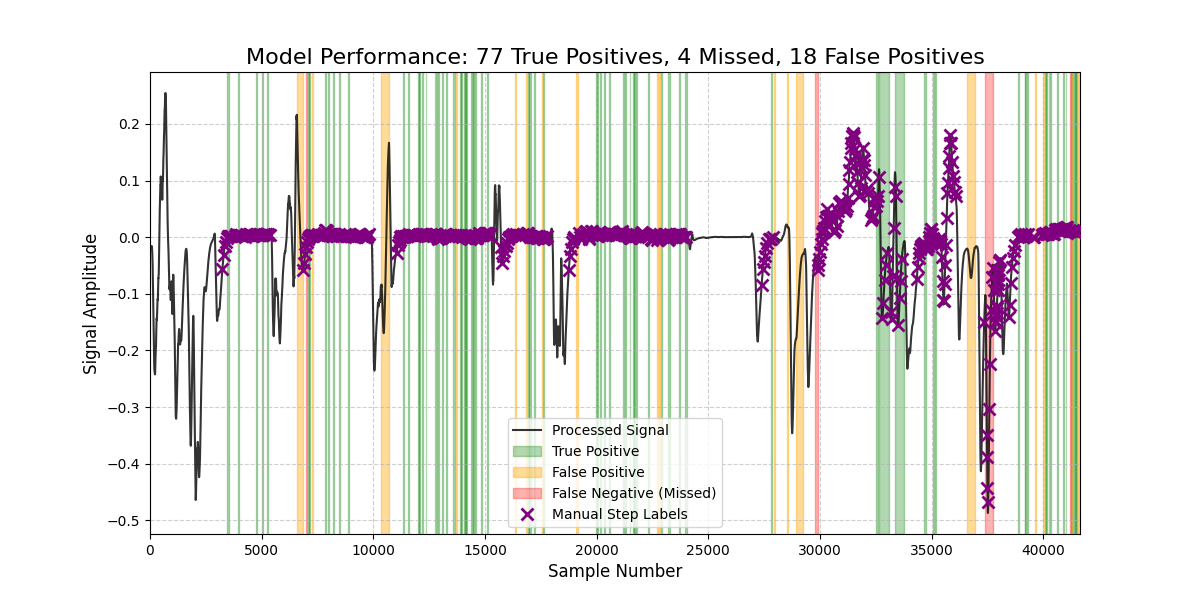

In [ ]:

# =================================================================
# 7. NEW: DETAILED VISUALIZATION OF MODEL PERFORMANCE
# =================================================================
plt.figure(figsize=(12, 6))

# --- Plot the main signal ---
plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)

# --- Plot the results using shaded areas ---
# True Positives (Green)
for i, interval in enumerate(true_positive_intervals):
    label = 'True Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='green', alpha=0.3, label=label, zorder=1)

# False Positives (Orange) - The model said "step" but it wasn't
for i, interval in enumerate(false_positive_intervals):
    label = 'False Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='orange', alpha=0.4, label=label, zorder=1)
    
# False Negatives (Red) - A real step that the model missed
for i, interval in enumerate(false_negative_intervals):
    label = 'False Negative (Missed)' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='red', alpha=0.3, label=label, zorder=1)

# --- Plot ground truth for reference ---
plt.plot(manual_steps_list, signal[manual_steps_list], 'x', color='purple', markersize=8, mew=2, label='Manual Step Labels', zorder=5)


# --- Final Touches ---
title = f"Model Performance: {len(true_positive_intervals)} True Positives, {len(false_negative_intervals)} Missed, {len(false_positive_intervals)} False Positives"
plt.title(title, fontsize=16)
plt.xlabel("Sample Number", fontsize=12)
plt.ylabel("Signal Amplitude", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Zoom into the area covered by the test set to see details
if len(intervals_test) > 0:
    plot_start = intervals_test[:, 0].min() - 200
    plot_end = intervals_test[:, 1].max() + 200
    plt.xlim(max(0, plot_start), min(len(signal), plot_end))

plt.show()

### Hyper parameter tuning

Usamos Bayesian Optimization mais uma vez, é time expensive treinar várias vezes redes neuronais, neste caso cada treino leva ~7s

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,precision_score, recall_score
import time

# --- Import the Bayesian Optimization tools ---
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# --- Define the Search Space for the Optimizer ---
# These are the hyperparameters we want to tune.
search_space = [
    Integer(20, 60, name='optimal_w'),
    Real(0.05, 0.8, name='alpha')
]

# --- Caching to speed things up ---
# The EMA calculation only depends on alpha. We can cache its result.
ema_cache = {}

# =================================================================
# 3. DEFINE THE OBJECTIVE FUNCTION
# =================================================================

import numpy as np
from sklearn.metrics import fbeta_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# ... (Keep your imports and search_space) ...

@use_named_args(search_space)
def objective(optimal_w, alpha):
    print(f"Trying: w = {optimal_w}, alpha = {alpha:.4f}")

    # --- Step A: Generate Signal ---
    alpha_key = f"{alpha:.6f}"
    if alpha_key not in ema_cache:
        ax_lp = exponential_moving_average(sensor_data['ax'], alpha=alpha)
        ay_lp = exponential_moving_average(sensor_data['ay'], alpha=alpha)
        az_lp = exponential_moving_average(sensor_data['az'], alpha=alpha)
        accel_mag_lp = np.sqrt(np.array(ax_lp)**2 + np.array(ay_lp)**2 + np.array(az_lp)**2) - 1.0
        ema_cache[alpha_key] = accel_mag_lp
    
    signal = simple_moving_average(ema_cache[alpha_key], window_size=optimal_w)

    # --- Step B: Feature Extraction ---
    X, y, _ = extract_and_label_features_by_containment(signal, manual_steps_list)
    
    # Safety Check
    if len(X) < 20 or len(np.unique(y)) < 2:
        return 1.0 

    # --- Step C: Stratified Split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)), 
        Dropout(0.2),
        Dense(16, activation='relu'), 
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    # FIX 1: LOWER THE CLASS WEIGHT
    # Your previous calculation was likely giving weights like 5.0 or 10.0.
    # This forces the model to guess "1" constantly.
    # We cap it at 2.0 or 3.0. We want to help the model, not force it.
    neg = len(y_train) - sum(y_train)
    pos = sum(y_train)
    calculated_weight = neg / pos if pos > 0 else 1.0
    
    # Take the smaller of the calculated weight OR 3.0
    safe_weight = min(calculated_weight, 3.0) 
    
    class_weight = {0: 1.0, 1: safe_weight}

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, class_weight=class_weight)
    
    # --- Step D: FIND HIGHEST PRECISION THRESHOLD ---
    y_probs = model.predict(X_test).flatten()
    
    best_score_in_run = 0.0
    
    # We scan thresholds. We are looking for the threshold that
    # gives the best F0.5 Score (Prioritizing Low False Positives)
    for thresh in np.linspace(0.4, 0.9, 15):
        y_pred_dynamic = (y_probs > thresh).astype(int)
        
        # BETA = 0.5 means Precision is weighted higher than Recall.
        # This penalizes False Positives heavily.
        current_score = fbeta_score(y_test, y_pred_dynamic, beta=0.5, zero_division=0)
        
        if current_score > best_score_in_run:
            best_score_in_run = current_score

    print(f"--> F0.5-Score: {best_score_in_run:.4f}")
    
    return 1.0 - best_score_in_run



print("\nStarting Bayesian Optimization to find best 'alpha' and 'optimal_w'...")
start_time = time.time()

# n_calls is your "budget" for how many combinations to test.
# 50-100 is a good starting point.
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=70,
    random_state=42,
    verbose=True
)

end_time = time.time()
print(f"\nOptimization complete in {end_time - start_time:.2f} seconds.")

# =================================================================
# 5. PRESENT THE BEST RESULTS
# =================================================================

best_f1_score = 1.0 - result.fun
best_parameters = result.x

print("\n" + "="*50)
print("           BEST PARAMETERS FOUND")
print("="*50)
print(f"\nBest F1-Score on Validation: {best_f1_score:.4f}")
print("Optimal Parameters:")
print(f"  - optimal_w: {best_parameters[0]}")
print(f"  - alpha:     {best_parameters[1]:.6f}")


Starting Bayesian Optimization to find best 'alpha' and 'optimal_w'...
Iteration No: 1 started. Evaluating function at random point.
Trying: w = 52, alpha = 0.1876


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F0.5-Score: 0.7692
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.3684
Function value obtained: 0.2308
Current minimum: 0.2308
Iteration No: 2 started. Evaluating function at random point.
Trying: w = 51, alpha = 0.4976


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7107
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.9867
Function value obtained: 0.2893
Current minimum: 0.2308
Iteration No: 3 started. Evaluating function at random point.
Trying: w = 38, alpha = 0.1250


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
--> F0.5-Score: 0.6882
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.0674
Function value obtained: 0.3118
Current minimum: 0.2308
Iteration No: 4 started. Evaluating function at random point.
Trying: w = 38, alpha = 0.3003


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F0.5-Score: 0.5824
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.8582
Function value obtained: 0.4176
Current minimum: 0.2308
Iteration No: 5 started. Evaluating function at random point.
Trying: w = 26, alpha = 0.5382


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7126
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.2048
Function value obtained: 0.2874
Current minimum: 0.2308
Iteration No: 6 started. Evaluating function at random point.
Trying: w = 22, alpha = 0.5915


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7875
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 6.4687
Function value obtained: 0.2125
Current minimum: 0.2125
Iteration No: 7 started. Evaluating function at random point.
Trying: w = 58, alpha = 0.0506


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F0.5-Score: 0.7903
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.7139
Function value obtained: 0.2097
Current minimum: 0.2097
Iteration No: 8 started. Evaluating function at random point.
Trying: w = 60, alpha = 0.5131


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7519
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 6.9509
Function value obtained: 0.2481
Current minimum: 0.2097
Iteration No: 9 started. Evaluating function at random point.
Trying: w = 44, alpha = 0.0553


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F0.5-Score: 0.6215
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.1467
Function value obtained: 0.3785
Current minimum: 0.2097
Iteration No: 10 started. Evaluating function at random point.
Trying: w = 21, alpha = 0.4436


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F0.5-Score: 0.8011
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 6.5562
Function value obtained: 0.1989
Current minimum: 0.1989
Iteration No: 11 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.0519


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
--> F0.5-Score: 0.8434
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 5.1172
Function value obtained: 0.1566
Current minimum: 0.1566
Iteration No: 12 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.0590


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F0.5-Score: 0.8207
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 5.1266
Function value obtained: 0.1793
Current minimum: 0.1566
Iteration No: 13 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.7798


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7957
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.3248
Function value obtained: 0.2043
Current minimum: 0.1566
Iteration No: 14 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.0500


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
--> F0.5-Score: 0.7895
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 5.1056
Function value obtained: 0.2105
Current minimum: 0.1566
Iteration No: 15 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.7945


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.8007
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 7.9146
Function value obtained: 0.1993
Current minimum: 0.1566
Iteration No: 16 started. Searching for the next optimal point.
Trying: w = 60, alpha = 0.7867


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7816
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.6790
Function value obtained: 0.2184
Current minimum: 0.1566
Iteration No: 17 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.0594


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F0.5-Score: 0.7843
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 4.7659
Function value obtained: 0.2157
Current minimum: 0.1566
Iteration No: 18 started. Searching for the next optimal point.
Trying: w = 56, alpha = 0.7983


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7732
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.1757
Function value obtained: 0.2268
Current minimum: 0.1566
Iteration No: 19 started. Searching for the next optimal point.
Trying: w = 60, alpha = 0.0545


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
--> F0.5-Score: 0.7495
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4.9806
Function value obtained: 0.2505
Current minimum: 0.1566
Iteration No: 20 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.7981


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7889
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.7993
Function value obtained: 0.2111
Current minimum: 0.1566
Iteration No: 21 started. Searching for the next optimal point.
Trying: w = 30, alpha = 0.0507


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
--> F0.5-Score: 0.8009
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 5.0345
Function value obtained: 0.1991
Current minimum: 0.1566
Iteration No: 22 started. Searching for the next optimal point.
Trying: w = 31, alpha = 0.7975


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F0.5-Score: 0.6667
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.1964
Function value obtained: 0.3333
Current minimum: 0.1566
Iteration No: 23 started. Searching for the next optimal point.
Trying: w = 25, alpha = 0.0500


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
--> F0.5-Score: 0.8237
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 4.6869
Function value obtained: 0.1763
Current minimum: 0.1566
Iteration No: 24 started. Searching for the next optimal point.
Trying: w = 33, alpha = 0.3845


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(25), 0.05] before, using random point [np.int64(33), 0.38450936922326645]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--> F0.5-Score: 0.7564
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 6.5767
Function value obtained: 0.2436
Current minimum: 0.1566
Iteration No: 25 started. Searching for the next optimal point.
Trying: w = 24, alpha = 0.0500


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
--> F0.5-Score: 0.8656
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.1300
Function value obtained: 0.1344
Current minimum: 0.1344
Iteration No: 26 started. Searching for the next optimal point.
Trying: w = 26, alpha = 0.0500


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
--> F0.5-Score: 0.8768
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 4.5628
Function value obtained: 0.1232
Current minimum: 0.1232
Iteration No: 27 started. Searching for the next optimal point.
Trying: w = 27, alpha = 0.0500


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
--> F0.5-Score: 0.8462
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 4.7114
Function value obtained: 0.1538
Current minimum: 0.1232
Iteration No: 28 started. Searching for the next optimal point.
Trying: w = 39, alpha = 0.3787


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(25), 0.05] before, using random point [np.int64(39), 0.3786724949424267]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F0.5-Score: 0.5758
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.3706
Function value obtained: 0.4242
Current minimum: 0.1232
Iteration No: 29 started. Searching for the next optimal point.
Trying: w = 49, alpha = 0.6001


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(49), 0.600136015722354]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--> F0.5-Score: 0.6542
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.1637
Function value obtained: 0.3458
Current minimum: 0.1232
Iteration No: 30 started. Searching for the next optimal point.
Trying: w = 28, alpha = 0.5582


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(28), 0.5582097607539915]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
--> F0.5-Score: 0.7399
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.3026
Function value obtained: 0.2601
Current minimum: 0.1232
Iteration No: 31 started. Searching for the next optimal point.
Trying: w = 41, alpha = 0.7935


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(25), 0.05] before, using random point [np.int64(41), 0.793525090174604]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.3780
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.4600
Function value obtained: 0.6220
Current minimum: 0.1232
Iteration No: 32 started. Searching for the next optimal point.
Trying: w = 20, alpha = 0.0660


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(20), 0.06603778851185722]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
--> F0.5-Score: 0.8124
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 5.6580
Function value obtained: 0.1876
Current minimum: 0.1232
Iteration No: 33 started. Searching for the next optimal point.
Trying: w = 55, alpha = 0.7811


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(55), 0.7810679890757757]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--> F0.5-Score: 0.7108
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 9.4007
Function value obtained: 0.2892
Current minimum: 0.1232
Iteration No: 34 started. Searching for the next optimal point.
Trying: w = 55, alpha = 0.4461


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(55), 0.4460735793880266]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7781
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 7.5357
Function value obtained: 0.2219
Current minimum: 0.1232
Iteration No: 35 started. Searching for the next optimal point.
Trying: w = 56, alpha = 0.3582


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(56), 0.35818169486421875]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7658
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 6.2284
Function value obtained: 0.2342
Current minimum: 0.1232
Iteration No: 36 started. Searching for the next optimal point.
Trying: w = 21, alpha = 0.4420


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(21), 0.4420004828106982]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.7879
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 6.4976
Function value obtained: 0.2121
Current minimum: 0.1232
Iteration No: 37 started. Searching for the next optimal point.
Trying: w = 46, alpha = 0.5667


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(46), 0.5667477823780405]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F0.5-Score: 0.5556
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 8.1671
Function value obtained: 0.4444
Current minimum: 0.1232
Iteration No: 38 started. Searching for the next optimal point.
Trying: w = 52, alpha = 0.2322


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24), 0.05] before, using random point [np.int64(52), 0.23217309227540556]
  warnings.warn(
/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F0.5-Score: 0.7595


KeyboardInterrupt: 

### Final Best Plot

In [ ]:
sensor_data['accel_magnitude'] = np.sqrt(sensor_data['ax']**2 + sensor_data['ay']**2 + sensor_data['az']**2) - 1

sensor_data['ax_lp'] = exponential_moving_average(sensor_data['ax'] , alpha=0.2)
sensor_data['ay_lp'] = exponential_moving_average(sensor_data['ay'] , alpha=0.2)
sensor_data['az_lp'] = exponential_moving_average(sensor_data['az'] , alpha=0.2)

sensor_data['accel_magnitude_lp'] = np.sqrt(sensor_data['ax_lp']**2 + sensor_data['ay_lp']**2 + sensor_data['az_lp']**2) - 1

signal = np.array(simple_moving_average(sensor_data['accel_magnitude_lp'], 50))

# --- Step B: Feature Extraction ---
X, y, intervals_test = extract_and_label_features_by_containment(signal, manual_steps_list)

model = Sequential([
    Dense(16, activation='relu', input_shape=(X.shape[1],)), Dropout(0.1),
    Dense(8, activation='relu'), Dropout(0.1),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=100, batch_size=8, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
            verbose=0)


In [ ]:
y_pred = (model.predict(X) > 0.5).astype(int).flatten()

true_positive_intervals = []
false_positive_intervals = []
false_negative_intervals = []

for i in range(len(X)):
    interval = intervals_test[i]
    true_label = y[i]
    predicted_label = y_pred[i]
    
    if predicted_label == 1 and true_label == 1:
        true_positive_intervals.append(interval)
    elif predicted_label == 1 and true_label == 0:
        false_positive_intervals.append(interval)
    elif predicted_label == 0 and true_label == 1:
        false_negative_intervals.append(interval)


# =================================================================
# 7. NEW: DETAILED VISUALIZATION OF MODEL PERFORMANCE
# =================================================================
plt.figure(figsize=(12, 8))

# --- Plot the main signal ---
plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)
# plt.plot(sensor_data['accel_magnitude'], color='purple', label='Processed Signal', zorder=2, alpha=0.4)


# --- Plot the results using shaded areas ---
# True Positives (Green)
for i, interval in enumerate(true_positive_intervals):
    label = 'True Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='green', alpha=0.3, label=label, zorder=1)

# False Positives (Orange) - The model said "step" but it wasn't
for i, interval in enumerate(false_positive_intervals):
    label = 'False Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='orange', alpha=0.4, label=label, zorder=1)
    
# False Negatives (Red) - A real step that the model missed
for i, interval in enumerate(false_negative_intervals):
    label = 'False Negative (Missed)' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='red', alpha=0.3, label=label, zorder=1)

# --- Plot ground truth for reference ---
plt.plot(manual_steps_list, signal[manual_steps_list], 'x', color='purple', markersize=8, mew=2, label='Manual Step Labels', zorder=5)


# --- Final Touches ---
title = f"Model Performance: {len(true_positive_intervals)} True Positives, {len(false_negative_intervals)} Missed, {len(false_positive_intervals)} False Positives"
plt.title(title, fontsize=16)
plt.xlabel("Sample Number", fontsize=12)
plt.ylabel("Signal Amplitude", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Zoom into the area covered by the test set to see details
if len(intervals_test) > 0:
    plot_start = intervals_test[:, 0].min() - 200
    plot_end = intervals_test[:, 1].max() + 200
    plt.xlim(max(0, plot_start), min(len(signal), plot_end))

plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
layer_index = 0

def format_cpp_array(name, array):
    array = np.array(array)
    if array.ndim == 1:
        # Bias vector
        s = f"static const float {name}[{array.shape[0]}] = {{\n"
        s += ", ".join(f"{v:.8e}f" for v in array)
        s += "};\n"
    elif array.ndim == 2:
        # Weight matrix
        rows, cols = array.shape
        s = f"static const float {name}[{rows}][{cols}] = {{\n"
        for r in range(rows):
            row_str = ", ".join(f"{v:.8e}f" for v in array[r])
            s += f"    {{ {row_str} }},\n"
        s += "};\n"
    else:
        raise ValueError("Wrong dimension")
    return s


for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) == 0:
        continue

    W, b = weights

    print(f"// Layer {layer_index}")

    # Print W
    print(format_cpp_array(f"W{layer_index}", W))

    # Print b
    print(format_cpp_array(f"b{layer_index}", b))

    layer_index += 1

// Layer 0
static const float W0[8][16] = {
    { 3.02557230e-01f, 8.72685313e-02f, 1.49618417e-01f, -4.82968122e-01f, 4.21085730e-02f, 7.42989630e-02f, 5.68179607e-01f, -3.90492119e-02f, 1.42172202e-01f, 3.14140797e-01f, 2.11109638e-01f, 3.40034008e-01f, 1.97876066e-01f, 3.23855758e-01f, 6.68497801e-01f, -3.53223801e-01f },
    { -1.37767792e-01f, -4.63212311e-01f, -6.07226491e-01f, -8.20845664e-02f, -5.78677878e-02f, -6.60201967e-01f, -3.69613826e-01f, 9.71890688e-02f, -1.07412236e-02f, -4.21767235e-02f, 6.82848692e-02f, 3.40093225e-01f, -1.26039296e-01f, 2.36894608e-01f, 1.81070298e-01f, 1.28003374e-01f },
    { 2.58733273e-01f, 1.96108982e-01f, 1.31660387e-01f, 4.84205633e-01f, -3.88868421e-01f, 4.62819219e-01f, 2.86736995e-01f, 3.41782600e-01f, 1.25250250e-01f, -3.37870121e-02f, -2.25858212e-01f, -3.12460572e-01f, -1.98015019e-01f, -1.09938383e-01f, 2.31020659e-01f, -4.27170247e-01f },
    { -9.18531418e-02f, 2.31822014e-01f, -5.77243380e-02f, -2.30238572e-01f, -4.09927666e-01f, 6

LIXO

--- Starting Bayesian Optimization (Finding best w & alpha) ---
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2943
Function value obtained: 0.1182
Current minimum: 0.1182
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3378
Function value obtained: 0.1875
Current minimum: 0.1182
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2636
Function value obtained: 0.2121
Current minimum: 0.1182
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3317
Function value obtained: 0.2651
Current minimum: 0.1182
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3414
Function value obtained: 0.

/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(70), 0.01] before, using random point [np.int64(36), 0.14423441243278218]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6011
Function value obtained: 0.1675
Current minimum: 0.0638
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4987
Function value obtained: 0.1163
Current minimum: 0.0638
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4970
Function value obtained: 0.1296
Current minimum: 0.0638
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3777
Function value obtained: 0.1813
Current minimum: 0.0638
Iteration No: 27 started. Searching for the next optimal point.


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(70), 0.01] before, using random point [np.int64(42), 0.2620515851693246]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5478
Function value obtained: 0.2636
Current minimum: 0.0638
Iteration No: 28 started. Searching for the next optimal point.


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(70), 0.01] before, using random point [np.int64(62), 0.41315851499843886]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5716
Function value obtained: 0.2182
Current minimum: 0.0638
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4411
Function value obtained: 0.1020
Current minimum: 0.0638
Iteration No: 30 started. Searching for the next optimal point.


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(70), 0.01] before, using random point [np.int64(54), 0.1711392433445651]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5639
Function value obtained: 0.1681
Current minimum: 0.0638
Iteration No: 31 started. Searching for the next optimal point.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.4687
Function value obtained: 0.1016
Current minimum: 0.0638
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.5817
Function value obtained: 0.0811
Current minimum: 0.0638
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.7889
Function value obtained: 0.0909
Current minimum: 0.0638
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.5211
Function value obtained: 0.0974
Current minimum: 0.0638
Iteration No: 35 started. Sea

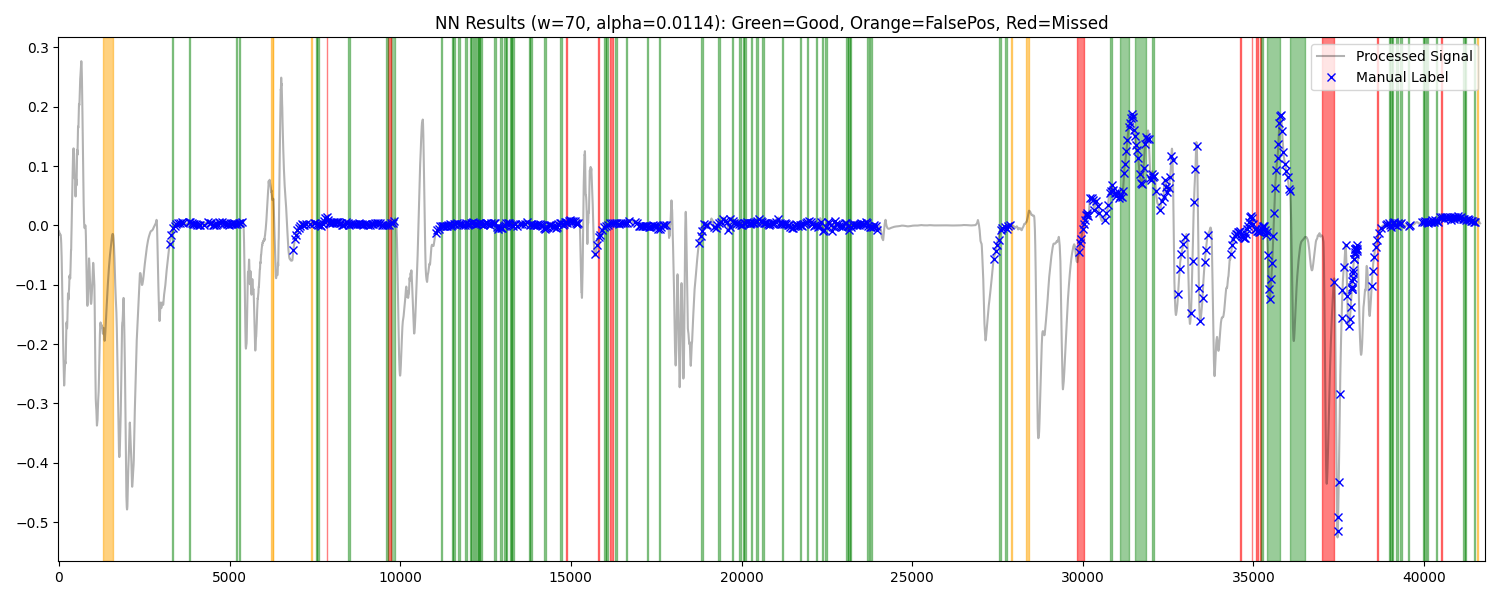

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- Optimizer Imports ---
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# =================================================================
# 1. HELPER FUNCTIONS (Signal Processing & Features)
# =================================================================

def exponential_moving_average(signal, alpha):
    """Numpy-fast implementation of EMA"""
    n = len(signal)
    ema = np.zeros(n)
    ema[0] = signal[0]
    for i in range(1, n):
        ema[i] = alpha * signal[i] + (1 - alpha) * ema[i-1]
    return ema

def simple_moving_average(signal, window_size):
    """Numpy-fast SMA"""
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(signal, window, 'same')

def extract_features_enhanced(signal, manual_step_samples):
    """Extracts 15 features per interval. NO CLEANING performed."""
    features = []
    labels = []
    detected_intervals = []
    
    state = "LOOKING_FOR_FIRST_MAX"
    max1_idx = -1
    min_idx = -1

    for i in range(1, len(signal) - 1):
        # Local Max
        if signal[i] > signal[i-1] and signal[i] > signal[i+1]:
            if state == "LOOKING_FOR_FIRST_MAX":
                state = "LOOKING_FOR_MIN"
                max1_idx = i
            elif state == "LOOKING_FOR_MIN":
                max1_idx = i
            elif state == "LOOKING_FOR_SECOND_MAX":
                max2_idx = i
                
                # Extract Features
                interval_slice = signal[max1_idx:max2_idx+1]
                duration = max2_idx - max1_idx
                
                if duration > 0:
                    val_max1 = signal[max1_idx]
                    val_min = signal[min_idx]
                    val_max2 = signal[max2_idx]
                    t1 = min_idx - max1_idx
                    t2 = max2_idx - min_idx
                    
                    # 15 Features vector
                    f_vec = [
                        val_max1, val_min, val_max2,
                        val_max1 - val_min, val_max2 - val_min, abs(val_max1 - val_max2),
                        (val_max1 - val_min)/t1, 
                        (val_max2 - val_min)/t2,
                        t1/duration, t2/duration, duration
                    ]
                    
                    features.append(f_vec)
                    detected_intervals.append([max1_idx, max2_idx])
                    
                    # Labeling (Containment)
                    is_step = any(max1_idx <= ms <= max2_idx for ms in manual_step_samples)
                    labels.append(1 if is_step else 0)

                state = "LOOKING_FOR_MIN"
                max1_idx = i

        # Local Min
        if signal[i] < signal[i-1] and signal[i] < signal[i+1]:
            if state == "LOOKING_FOR_MIN":
                state = "LOOKING_FOR_SECOND_MAX"
                min_idx = i

    return np.array(features), np.array(labels), np.array(detected_intervals)

# =================================================================
# 2. BAYESIAN OPTIMIZATION SETUP
# =================================================================

# Define Search Space
search_space = [
    Integer(20, 80, name='optimal_w'),
    Real(0.01, 0.5, name='alpha')
]

ema_cache = {} # Cache to speed up the loop

@use_named_args(search_space)
def objective(optimal_w, alpha):
    # 1. Generate Signal
    alpha_key = f"{alpha:.6f}"
    if alpha_key not in ema_cache:
        # Assuming sensor_data is global
        ax_lp = exponential_moving_average(sensor_data['ax'].values, alpha)
        ay_lp = exponential_moving_average(sensor_data['ay'].values, alpha)
        az_lp = exponential_moving_average(sensor_data['az'].values, alpha)
        mag = np.sqrt(ax_lp**2 + ay_lp**2 + az_lp**2) - 1.0
        ema_cache[alpha_key] = mag
    
    signal = simple_moving_average(ema_cache[alpha_key], optimal_w)

    # 2. Extract Features (Raw, No Cleanup)
    X, y, _ = extract_features_enhanced(signal, manual_steps_list)

    # Safety check
    if len(X) < 50 or len(np.unique(y)) < 2:
        return 1.0

    # 3. Train Fast Model (Random Forest) for Optimization Score
    # We use RF here because it's 10x faster than NN for looping
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    rf = RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Minimize (1 - F1)
    return 1.0 - f1_score(y_test, y_pred, zero_division=0)

# =================================================================
# 3. RUN OPTIMIZATION
# =================================================================
print("--- Starting Bayesian Optimization (Finding best w & alpha) ---")
start_t = time.time()

result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=50, # 50 iterations
    random_state=42,
    verbose=True
)

print(f"\nOptimization done in {time.time()-start_t:.1f}s")
best_w = result.x[0]
best_alpha = result.x[1]
print(f"BEST PARAMETERS: w={best_w}, alpha={best_alpha:.4f}")

# =================================================================
# 4. TRAIN FINAL NEURAL NETWORK (Using Best Params)
# =================================================================
print("\n--- Training Final Neural Network with Best Parameters ---")

# 1. Re-generate best signal
ax_lp = exponential_moving_average(sensor_data['ax'].values, best_alpha)
ay_lp = exponential_moving_average(sensor_data['ay'].values, best_alpha)
az_lp = exponential_moving_average(sensor_data['az'].values, best_alpha)
mag = np.sqrt(ax_lp**2 + ay_lp**2 + az_lp**2) - 1.0
best_signal = simple_moving_average(mag, best_w)

# 2. Extract Data
X, y, intervals = extract_features_enhanced(best_signal, manual_steps_list)

# 3. Split & Scale (Neural Nets NEED Scaling)
X_train, X_test, y_train, y_test, int_train, int_test = train_test_split(
    X, y, intervals, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Build Model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate weights because we didn't clean the data
neg = len(y_train) - sum(y_train)
pos = sum(y_train)
ratio = neg / pos if pos > 0 else 1.0
weights = {0: 1.0, 1: min(ratio, 3.0)} # Cap weight at 3.0 to prevent False Positive explosion

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    class_weight=weights,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

print("Neural Network Training Complete.")

# =================================================================
# 5. STATISTICS & VISUALIZATION
# =================================================================

# Predict
y_probs = model.predict(X_test).flatten()
# Optional: Find best threshold (usually 0.5 is fine if model is good)
y_pred = (y_probs > 0.5).astype(int)

# Stats
cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

print("\n" + "="*40)
print("       FINAL RESULTS")
print("="*40)
print(f"Accuracy:  {(tp+tn)/len(y_test):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print("-" * 20)
print(f"True Steps Found (TP):      {tp}")
print(f"True Steps Missed (FN):     {fn}")
print(f"False Alarms (FP):          {fp}")
print("-" * 20)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Noise', 'Step']))

# --- PLOT ---
plt.figure(figsize=(15, 6))
plt.plot(best_signal, color='black', alpha=0.3, label='Processed Signal')

# Limit plotting to first 500 test intervals to keep plot readable
plot_limit = min(len(int_test), 500)
print(f"Visualizing first {plot_limit} test intervals...")

for i in range(plot_limit):
    start, end = int_test[i]
    pred = y_pred[i]
    truth = y_test[i]
    
    if pred == 1 and truth == 1:
        color = 'green' # TP
        alpha = 0.4
    elif pred == 1 and truth == 0:
        color = 'orange' # FP
        alpha = 0.5
    elif pred == 0 and truth == 1:
        color = 'red' # FN (Missed)
        alpha = 0.5
    else:
        continue 

    plt.axvspan(start, end, color=color, alpha=alpha)

plt.plot(manual_steps_list, best_signal[manual_steps_list], 'bx', label='Manual Label')
plt.title(f"NN Results (w={best_w}, alpha={best_alpha:.4f}): Green=Good, Orange=FalsePos, Red=Missed")
plt.legend(loc='upper right')

# Zoom roughly to test area
if len(int_test) > 0:
    plt.xlim(int_test[:,0].min() - 200, int_test[:,1].max() + 200)

plt.tight_layout()
plt.show()